In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score, matthews_corrcoef, f1_score, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
# from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload
# %load_ext autoreload
# %autoreload 2
import lightgbm
from sklearn.metrics import recall_score, classification_report, auc, roc_curve

In [8]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: gosam 2.1.1-4b98559 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gosam or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
%load_ext autoreload
%autoreload 2
import lightgbm

ModuleNotFoundError: No module named 'lightgbm'

In [2]:
def read_parq(Fe_key = False):
    Data_weighted_1 = {}
    keys = ["mu", "tau"]
    for key in keys:
        Data_weighted_1[key] = pq.read_table(f"{key}_weighted_E{'_Fe' if Fe_key else ''}_fixed.parquet").to_pandas()
#         Data_weighted_1[key] = pq.read_table(f"{key}_weighted_E_advsnd.parquet").to_pandas()
    return Data_weighted_1



Data = read_parq(Fe_key = True)
#neutrals = ["pi0", "neutron", "gamma", 'K0', 'K0_bar', 'K_L0', 'Lambda0', 'Lambda0_bar', "antineutron", 'nu_e_bar']
#neutrals = ["neutron", "antineutron", 'nu_e_bar', 'K0', 'K0_bar', 'K_L0', 'HardBlob']
neutrals = []
#neutrals = []
# for key in Data:
#     Data[key]["P_in"] = np.sqrt(Data[key]["px"]**2 + Data[key]["py"]**2 + Data[key]["pz"]**2)
muon_data_numu = Data["mu"].query("final == 1 & m_id == 0 & abs(id) == 13").copy().set_index("Event").drop(columns = ["name"])
#####
#hadron_data_numu = Data["mu"].loc[~Data["mu"].name.isin(neutrals)].query("final == 1 & m_id != 0 & pz > 0").drop(columns = ["name"]).groupby("Event").sum()
hadron_data_numu = Data["mu"].query("id == 2000000001").drop(columns = ["name"]).groupby("Event").sum()
#####
muon_data_numu.columns = [col + "_mu" for col in muon_data_numu.columns]
hadron_data_numu.columns = [col + "_hadr" for col in hadron_data_numu.columns]
nu_data_numu = pd.DataFrame(Data["mu"].query("m_id == -1 & abs(id) == 14")["pz"])
nu_data_numu.columns = ["P_nu"]
muon_data_numu = pd.concat([muon_data_numu, hadron_data_numu], axis = 1)
#print(muon_data_numu)
muon_data_numu["label"] = pd.Series(len(muon_data_numu["id_mu"])*["numu"])
muon_data_nutau = Data["tau"].query("final == 1 & m_id == 0 & abs(id) == 13").copy().set_index("Event").drop(columns = ["name"])
#####
#hadron_data_nutau = Data["tau"].loc[~Data["tau"].name.isin(neutrals)].query("final == 1 & m_id != 0 & pz > 0").drop(columns = ["name"]).groupby("Event").sum()
hadron_data_nutau = Data["tau"].query("id == 2000000001").drop(columns = ["name"]).groupby("Event").sum()
#####
muon_data_nutau.columns = [col + "_mu" for col in muon_data_nutau.columns]
hadron_data_nutau.columns = [col + "_hadr" for col in hadron_data_nutau.columns]
nu_data_nutau = pd.DataFrame(Data["tau"].query("m_id == -1 & abs(id) == 16")["pz"])
nu_data_nutau.columns = ["P_nu"]
muon_data_nutau = pd.concat([muon_data_nutau, hadron_data_nutau], axis = 1)
muon_data_nutau["label"] = pd.Series(len(muon_data_nutau["id_mu"])*["nutau"])
df_muon = pd.concat([muon_data_numu, muon_data_nutau], ignore_index = True)
df_muon["px_miss"] = -df_muon["px_mu"].values - df_muon["px_hadr"].values
df_muon["py_miss"] = -df_muon["py_mu"].values - df_muon["py_hadr"].values
#df_muon["pz_miss"] = df_muon["P_nu"].values - df_muon["pz_mu"].values - df_muon["pz_hadr"].values
#df_muon["P_miss"] = np.sqrt(df_muon["px_miss"]**2 + df_muon["py_miss"]**2 + df_muon["pz_miss"]**2)
### smearing
# df_muon["E_hadr"] = np.random.normal(df_muon["E_hadr"], 0.1*df_muon["E_hadr"])
# df_muon["E_mu"] = np.random.normal(df_muon["E_mu"], 0.15*df_muon["E_mu"])
###

muon_sin = np.sqrt(df_muon["px_mu"].values**2 + df_muon["py_mu"].values**2)/np.sqrt(df_muon["px_mu"].values**2 + df_muon["py_mu"].values**2 + df_muon["pz_mu"].values**2)
hadr_sin = np.sqrt(df_muon["px_hadr"].values**2 + df_muon["py_hadr"].values**2)/np.sqrt(df_muon["px_hadr"].values**2 + df_muon["py_hadr"].values**2 + df_muon["pz_hadr"].values**2)
df_muon["Pt_miss"] = np.abs(df_muon["E_hadr"].values*hadr_sin - df_muon["E_mu"].values*muon_sin)
df_muon["Pt_hadr"] = df_muon["E_hadr"].values*hadr_sin
df_muon["Pt_mu"] = df_muon["E_mu"].values*muon_sin


df_muon["Pt_miss_old"] = np.sqrt(df_muon["px_miss"]**2 + df_muon["py_miss"]**2)
#df_muon["Pt_miss"] = df_muon["Pt_miss_old"]
df_muon["Pt_mu_old"] = np.sqrt(df_muon["px_mu"]**2 + df_muon["py_mu"]**2)
df_muon["P_mu_old"] = np.sqrt(df_muon["px_mu"]**2 + df_muon["py_mu"]**2 + df_muon["pz_mu"]**2)
df_muon["Pt_hadr_old"] = np.sqrt(df_muon["px_hadr"]**2 + df_muon["py_hadr"]**2)
df_muon["P_hadr_old"] = np.sqrt(df_muon["px_hadr"]**2 + df_muon["py_hadr"]**2 + df_muon["pz_hadr"]**2)


# df_muon["Pt_miss"] = np.abs(df_muon["E_hadr"].values*hadr_sin - df_muon["E_mu"].values*muon_sin)
# df_muon["Pt_hadr"] = df_muon["E_hadr"].values*hadr_sin
# df_muon["Pt_mu"] = df_muon["E_mu"].values*muon_sin

# df_muon["Pt_miss"] = df_muon["Pt_miss_old"]
# df_muon["Pt_hadr"] = df_muon["Pt_hadr_old"]
# df_muon["Pt_mu"] = df_muon["Pt_mu_old"]

df_muon["Pt_miss/E_mu"] = df_muon["Pt_miss"]/df_muon["E_mu"]
df_muon["Pt_miss/E_hadr"] = df_muon["Pt_miss"]/df_muon["E_hadr"]
df_muon["Pt_miss/Pt_mu"] = df_muon["Pt_miss"]/df_muon["Pt_mu"]
df_muon["Pt_miss/Pt_hadr"] = df_muon["Pt_miss"]/df_muon["Pt_hadr"]
df_muon["E_mu/E_hadr"] = df_muon["E_mu"]/df_muon["E_hadr"]
df_muon["Pt_mu/Pt_hadr"] = df_muon["Pt_mu"]/df_muon["Pt_hadr"]
df_muon["Pt_mu/E_hadr"] = df_muon["Pt_mu"]/df_muon["E_hadr"]
df_muon["Pt_hadr/E_mu"] = df_muon["Pt_hadr"]/df_muon["E_mu"]

df_muon["Pt_missxE_mu"] = df_muon["Pt_miss"]*df_muon["E_mu"]

# df_muon["E_mu/Pt_miss"] = df_muon["E_mu"]/df_muon["Pt_miss"]
# df_muon["E_hadr/Pt_miss"] = df_muon["E_hadr"]/df_muon["Pt_miss"]
# df_muon["Pt_miss/Pt_mu"] = df_muon["Pt_miss"]/df_muon["Pt_mu"]
# df_muon["Pt_hadr/Pt_miss"] = df_muon["Pt_hadr"]/df_muon["Pt_miss"]
# df_muon["E_hadr/E_mu"] = df_muon["E_hadr"]/df_muon["E_mu"]
# df_muon["Pt_hadr/Pt_mu"] = df_muon["Pt_hadr"]/df_muon["Pt_mu"]

df_muon["anglePtmissandPtmuon"] = np.arccos((-df_muon["px_miss"].values*df_muon["px_mu"].values - df_muon["py_miss"].values*df_muon["py_mu"].values)/(df_muon["Pt_miss_old"].values*df_muon["Pt_mu_old"].values))
df_muon["anglePtmissandPthadr"] = np.arccos((-df_muon["px_miss"]*df_muon["px_hadr"] - df_muon["py_miss"]*df_muon["py_hadr"])/(df_muon["Pt_miss_old"]*df_muon["Pt_hadr_old"]))
df_muon["anglePtmuonandPthadr"] = np.arccos((-df_muon["px_mu"]*df_muon["px_hadr"] - df_muon["py_mu"]*df_muon["py_hadr"])/(df_muon["Pt_mu_old"]*df_muon["Pt_hadr_old"]))

# df_muon["anglePtmissandPtmuon"] = np.arccos()


df_muon["anglePtmissandPtmuon"] = 180*df_muon["anglePtmissandPtmuon"]/np.pi
df_muon["anglePtmissandPthadr"] = 180*df_muon["anglePtmissandPthadr"]/np.pi
df_muon["anglePtmuonandPthadr"] = 180*df_muon["anglePtmuonandPthadr"]/np.pi


#df_muon["Pt_mu_on_Pt_miss"] = (df_muon["px_miss"]*df_muon["px_mu"] + df_muon["py_miss"]*df_muon["py_mu"])/df_muon["Pt_miss"]
#df_muon["Pt_hadr_on_Pt_miss"] = (df_muon["px_miss"]*df_muon["px_hadr"] + df_muon["py_miss"]*df_muon["py_hadr"])/df_muon["Pt_miss"]
p_muon = np.sqrt(df_muon["px_mu"]**2 + df_muon["py_mu"]**2 + df_muon["pz_mu"]**2)
p_hadr = np.sqrt(df_muon["px_hadr"]**2 + df_muon["py_hadr"]**2 + df_muon["pz_hadr"]**2)
df_muon["anglePhadrandPmuon"] = np.arccos((df_muon["px_hadr"]*df_muon["px_mu"] + df_muon["py_hadr"]*df_muon["py_mu"] + df_muon["pz_hadr"]*df_muon["pz_mu"])/(p_muon*p_hadr))

df_muon["anglePhadrandPmuon"] = 180*df_muon["anglePhadrandPmuon"]/np.pi

corrected_weight = df_muon.query("label == 'nutau'")["weight_mu"] / 5.
df_muon.loc[:, "weight_mu"] = pd.Series(df_muon.query("label == 'numu'")["weight_mu"].to_list() + corrected_weight.to_list())

df_muon_1 = df_muon.dropna()
excluded_list = ['Number_mu', 'id_mu', 'm_id_mu', 'final_mu', 'Xin_mu', 'Yin_mu', 'Zin_mu', 'Rin_mu',
       'Number_hadr', 'id_hadr', 'm_id_hadr', 'final_hadr', 'Xin_hadr', 'Yin_hadr', 'Zin_hadr', 'Rin_hadr',
       'weight_hadr', 'px_miss', 'py_miss', 'px_hadr', 'py_hadr', 'pz_hadr', 'P_in_hadr', 'P_hadr', 'P_in_mu', 
                 'Pt_miss_old', 'Pt_mu_old', 'P_mu_old', 'Pt_hadr_old', 'P_hadr_old']

df_muon_1 = df_muon_1.loc[:, ~df_muon_1.columns.isin(excluded_list)]
X = df_muon_1.drop(columns = ["label"])
df_muon_1

,px_mu,py_mu,pz_mu,E_mu,weight_mu,E_hadr,label,Pt_miss,Pt_hadr,Pt_mu,...,Pt_miss/Pt_hadr,E_mu/E_hadr,Pt_mu/Pt_hadr,Pt_mu/E_hadr,Pt_hadr/E_mu,Pt_missxE_mu,anglePtmissandPtmuon,anglePtmissandPthadr,anglePtmuonandPthadr,anglePhadrandPmuon
0,-3.025240,-1.341180,32.353200,32.522100,1.422374,48.79440,numu,0.208771,3.517987,3.309216,...,0.059344,0.666513,0.940656,0.067820,0.108172,6.789677,171.966007,7.640857,0.393136,9.974566
1,-2.293630,0.135870,42.693800,42.755800,2.033576,29.63330,numu,0.263773,2.561436,2.297663,...,0.102979,1.442830,0.897021,0.077537,0.059909,11.277840,164.361875,14.409964,1.228160,8.038783
2,1.024890,-1.197050,51.643500,51.667700,3.024684,4.83676,numu,0.429089,2.004952,1.575863,...,0.214015,10.682296,0.785985,0.325810,0.038805,22.170052,171.955260,7.164262,0.880478,26.236928
3,3.591800,-2.457970,47.029500,47.230600,1.755399,29.27210,numu,0.042783,4.395111,4.352328,...,0.009734,1.613502,0.990266,0.148685,0.093056,2.020678,15.040206,164.710907,0.248887,13.922741
4,0.410113,0.013879,14.697700,14.703800,8.193070,2.80801,numu,0.495395,0.905753,0.410358,...,0.546943,5.236377,0.453057,0.146138,0.061600,7.284190,176.872900,2.003952,1.123148,20.416799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.118077,1.131871,3.275532,3.469210,0.008962,79.61990,nutau,0.046760,1.091784,1.138544,...,0.042829,0.043572,1.042829,0.014300,0.314707,0.162221,72.044335,90.178508,17.777157,19.908242
199996,-0.837029,-0.070800,4.073671,4.160728,0.006871,79.47910,nutau,1.137091,1.977382,0.840291,...,0.575049,0.052350,0.424951,0.010572,0.475249,4.731127,120.776932,21.559927,37.663141,12.809245
199997,0.691892,-0.228120,46.162623,46.168493,0.010733,21.31350,nutau,0.870810,1.599340,0.728530,...,0.544481,2.166162,0.455519,0.034182,0.034641,40.203999,160.681886,9.039988,10.278126,5.195600
199998,0.045558,-0.521872,1.428108,1.524845,0.011344,58.27960,nutau,1.789389,2.314515,0.525127,...,0.773116,0.026164,0.226884,0.009010,1.517869,2.728541,83.632948,13.116687,83.250365,20.531080


Index(['px_mu', 'py_mu', 'pz_mu', 'E_mu', 'weight_mu', 'E_hadr', 'label',
       'Pt_miss', 'Pt_hadr', 'Pt_mu', 'Pt_miss/E_mu', 'Pt_miss/E_hadr',
       'Pt_miss/Pt_mu', 'Pt_miss/Pt_hadr', 'E_mu/E_hadr', 'Pt_mu/Pt_hadr',
       'E_mu/Pt_miss', 'E_hadr/Pt_miss', 'Pt_hadr/Pt_miss', 'E_hadr/E_mu',
       'Pt_hadr/Pt_mu', 'anglePtmissandPtmuon', 'anglePtmissandPthadr',
       'anglePtmuonandPthadr', 'anglePhadrandPmuon'],
      dtype='object')

In [53]:
df_muon_1["weight_mu"]

0         1.422374
1         2.033576
2         3.024684
3         1.755399
4         8.193070
            ...   
199995    0.008962
199996    0.006871
199997    0.010733
199998    0.011344
199999    0.005674
Name: weight_mu, Length: 199743, dtype: float64

In [45]:
corrected_weight = df_muon_1.query("label == 'nutau'")["weight_mu"] / 5.


pd.Series(df_muon_1.query("label == 'numu'")["weight_mu"].to_list() + corrected_weight.to_list()).reindex(df_muon_1.index)


0         1.422374
1         2.033576
2         3.024684
3         1.755399
4         8.193070
            ...   
199995         NaN
199996         NaN
199997         NaN
199998         NaN
199999         NaN
Length: 199743, dtype: float64

In [39]:
df_muon_1.index

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       199990, 199991, 199992, 199993, 199994, 199995, 199996, 199997, 199998,
       199999],
      dtype='int64', length=199743)

In [44]:
df_muon_1["weight_mu"] = pd.Series(df_muon_1.query("label == 'numu'")["weight_mu"].to_list() + corrected_weight.to_list()).reindex(df_muon_1.index)


df_muon_1["weight_mu"]

0         1.422374
1         2.033576
2         3.024684
3         1.755399
4         8.193070
            ...   
199995         NaN
199996         NaN
199997         NaN
199998         NaN
199999         NaN
Name: weight_mu, Length: 199743, dtype: float64

In [64]:
df_muon_1.query("label == 'nutau'")["weight_mu"].sum()/df_muon_1.query("label == 'numu'")["weight_mu"].sum()

0.0027135886202507642

In [3]:
df = pd.read_csv("df_autoencoder_dataset.csv")
df = df.loc[:, ~df.columns.isin(["Unnamed: 0"])]
df

,px_mu,py_mu,pz_mu,E_mu,E_hadr,label,Pt_miss,Pt_hadr,Pt_mu,Pt_miss/E_mu,...,E_mu/Pt_miss,E_hadr/Pt_miss,Pt_hadr/Pt_miss,E_hadr/E_mu,Pt_hadr/Pt_mu,anglePtmissandPtmuon,anglePtmissandPthadr,Pt_mu_on_Pt_miss,Pt_hadr_on_Pt_miss,anglePhadrandPmuon
0,0.384047,-1.335320,11.416600,11.501300,125.894440,numu,0.270173,1.659678,1.389506,0.023491,...,42.570155,465.977397,6.143025,10.946105,1.194438,0.985289,2.366761,1.179177,-1.816348,0.134030
1,-2.206990,-0.360955,58.114900,58.158100,24.485145,numu,0.416729,1.819591,2.236320,0.007165,...,139.558617,58.755581,4.366367,0.421010,0.813654,2.616671,1.191485,-6.912303,1.595662,0.107276
2,1.730460,-0.324762,18.773200,18.855900,31.831244,numu,2.162280,3.922980,1.760701,0.114674,...,8.720380,14.721151,1.814280,1.688132,2.228079,1.877791,1.707557,-0.187759,-0.081508,0.211833
3,0.151511,-0.404163,1.091980,1.178940,30.122318,numu,0.071115,0.362259,0.433375,0.060321,...,16.577846,423.569609,5.093963,25.550340,0.835903,2.361378,1.080619,-0.624517,0.329816,0.387927
4,1.927280,0.907398,11.646600,11.840200,83.294526,numu,0.358640,1.771637,2.130277,0.030290,...,33.014143,232.250925,4.939871,7.034892,0.831646,2.556296,0.751280,-2.552889,1.811548,0.201913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.451819,0.029127,30.385553,30.389110,4.370572,nutau,0.111530,0.564289,0.452759,0.003670,...,272.475415,39.187505,5.059540,0.143820,1.246333,2.498570,2.497093,-2.350679,-2.343457,0.126118
9996,-0.168757,-0.069749,0.660279,0.693216,10.165327,nutau,1.202074,1.386850,0.184776,1.734054,...,0.576683,8.456492,1.153714,14.664017,7.505576,0.638454,3.049327,0.125578,-1.007222,0.393076
9997,0.546701,-0.722027,40.328943,40.339250,10.886403,nutau,2.416437,3.322092,0.905655,0.059903,...,16.693688,4.505146,1.374789,0.269871,3.668165,0.768840,2.800885,0.303101,-0.827076,0.330660
9998,0.526418,-0.052036,11.492397,11.505054,35.797378,nutau,3.691890,4.220897,0.529007,0.320893,...,3.116304,9.696219,1.143289,3.111448,7.978913,0.891697,3.042024,0.340913,-4.227808,0.153995


Number of nutau events 75745, percentage: 70.14082637840207%
px_mu. Range for numu: [-6.46002 7.01509]
px_mu. Range for nutau: [-5.610255745605085 5.665821700574236]
px_mu is a bad parameter
average point: nan, difference: nan
tau point: nan


/var/folders/8q/10g2kvdx0d71nvvyj7xyg2l40000gn/T/ipykernel_85506/2992024109.py:39: RuntimeWarning: invalid value encountered in log10
  bins = np.logspace(np.log10(min(Data_conv[param])), np.log10(max(Data_conv[param])), 200)
/var/folders/8q/10g2kvdx0d71nvvyj7xyg2l40000gn/T/ipykernel_85506/2992024109.py:62: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


py_mu. Range for numu: [-7.41449 6.50858]
py_mu. Range for nutau: [-6.52620161588676 5.993648612341808]
py_mu is a bad parameter
average point: nan, difference: nan
tau point: nan


/var/folders/8q/10g2kvdx0d71nvvyj7xyg2l40000gn/T/ipykernel_85506/2992024109.py:39: RuntimeWarning: invalid value encountered in log10
  bins = np.logspace(np.log10(min(Data_conv[param])), np.log10(max(Data_conv[param])), 200)
/var/folders/8q/10g2kvdx0d71nvvyj7xyg2l40000gn/T/ipykernel_85506/2992024109.py:62: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


pz_mu. Range for numu: [0.0701642 142.691]
pz_mu. Range for nutau: [0.043885265233970294 129.03993592573596]
average point: 18.164553879107622, difference: 62.822180522664894
tau point: 12.458869464572764
E_mu. Range for numu: [0.128042 142.696]
E_mu. Range for nutau: [0.1150427233771468 129.05164690168988]
average point: 17.951275440583988, difference: 65.50453914389877
tau point: 12.071825316680775
E_hadr. Range for numu: [1.16399 143.385]
E_hadr. Range for nutau: [1.38734 139.733]
E_hadr is a bad parameter
average point: 28.88884424644442, difference: 38.226964343468254
tau point: 34.41050834110862
Pt_miss. Range for numu: [1.104753892366972e-06 0.6121131297716502]
Pt_miss. Range for nutau: [5.336074023992721e-05 6.84811485507191]
average point: 0.8419712893223881, difference: 165.41987839410166
tau point: 1.5383652307775602
Pt_hadr. Range for numu: [0.01602922146655945 7.598459473713137]
Pt_hadr. Range for nutau: [0.008706461486661508 7.6438288410288875]
average point: 1.9857551985

/var/folders/8q/10g2kvdx0d71nvvyj7xyg2l40000gn/T/ipykernel_85506/2992024109.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize = (6,6), dpi = 100)


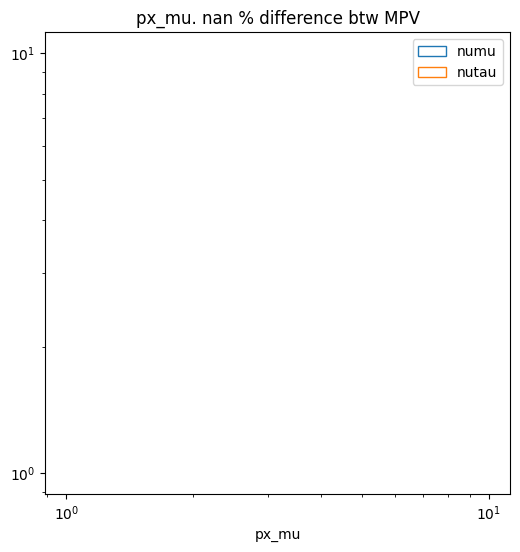

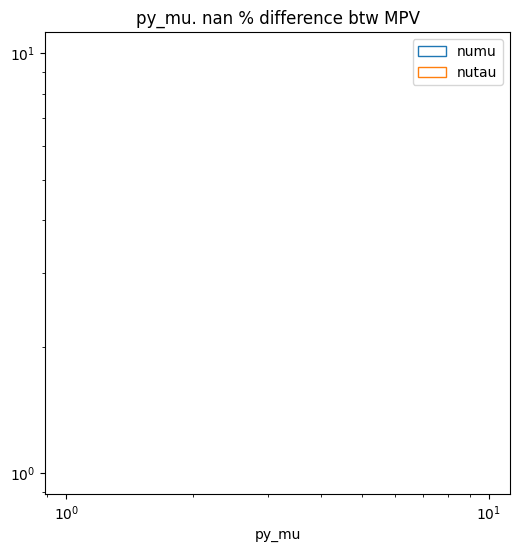

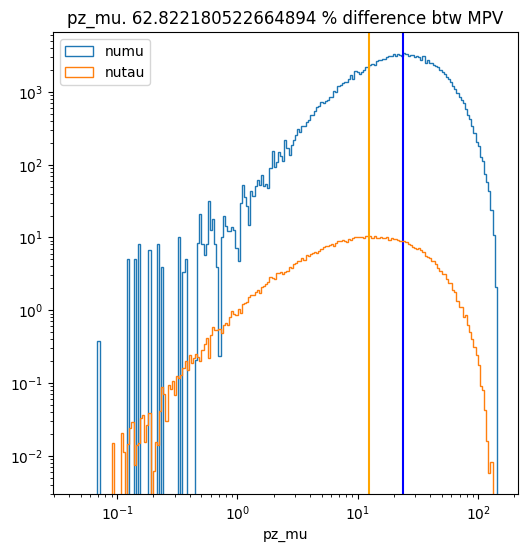

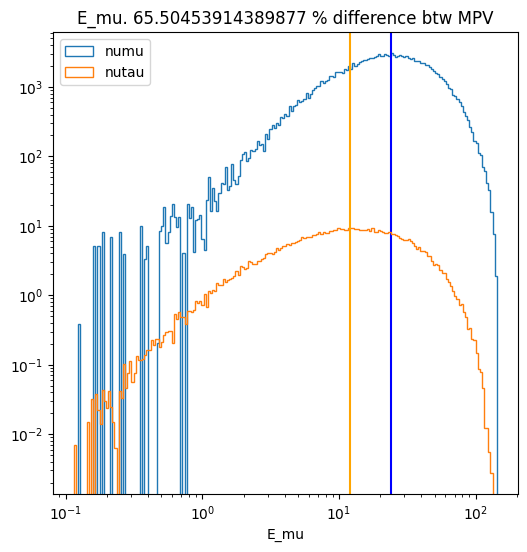

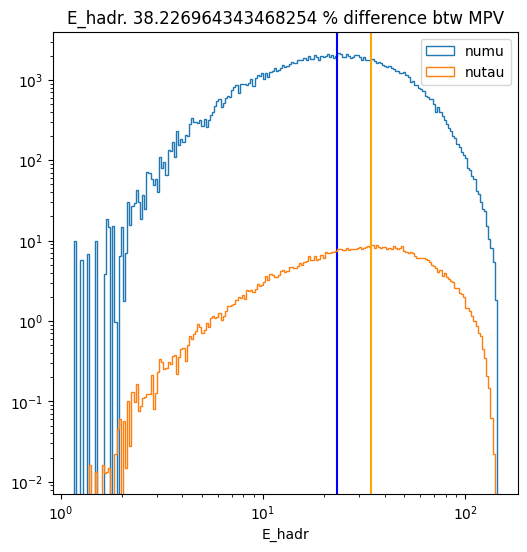

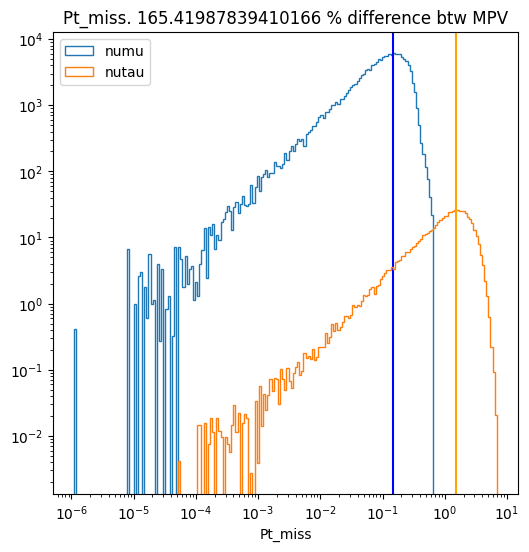

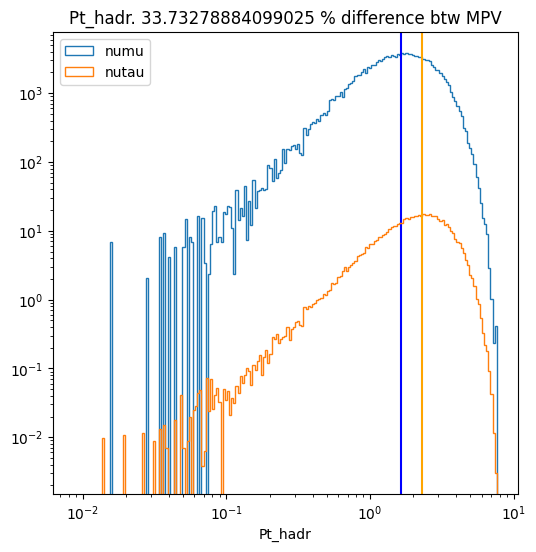

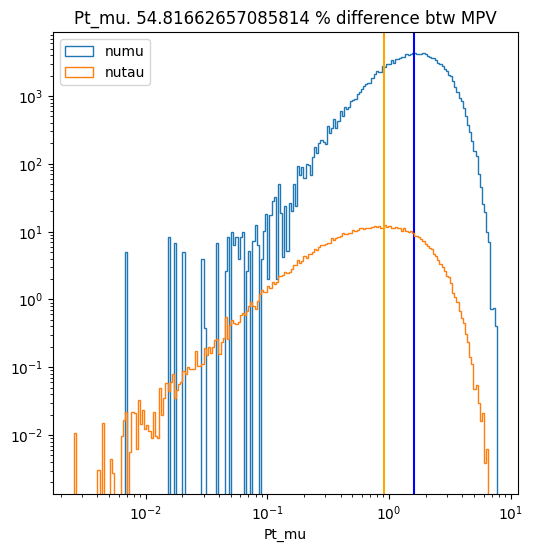

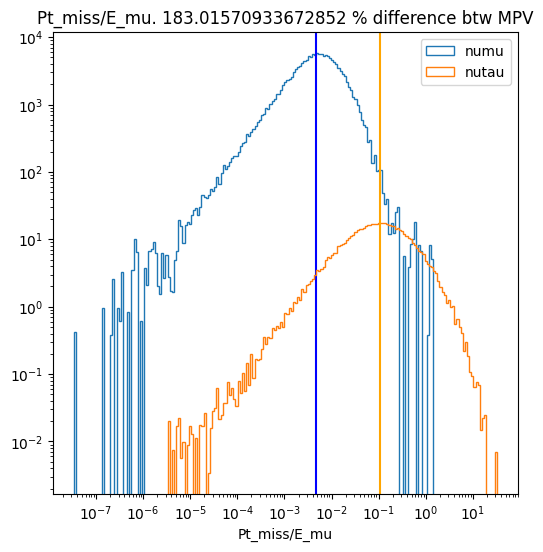

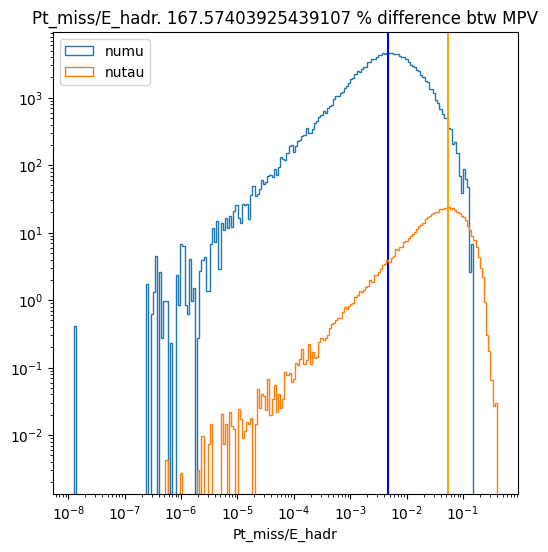

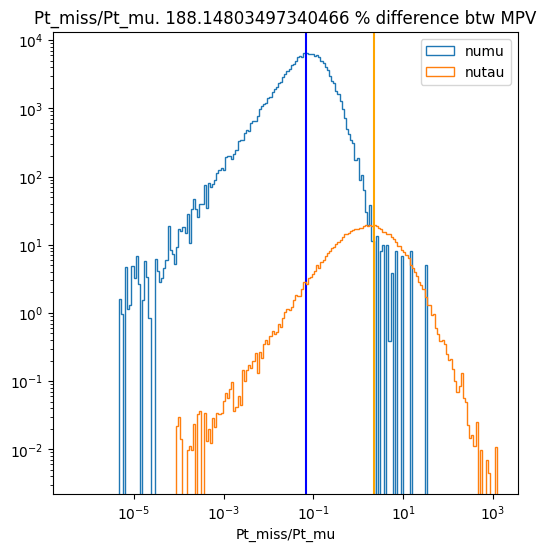

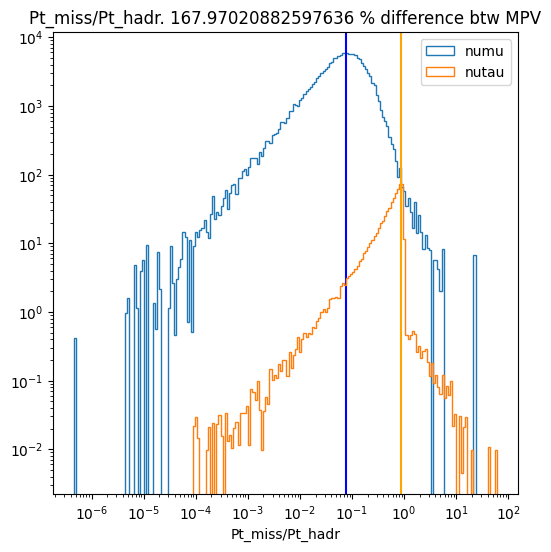

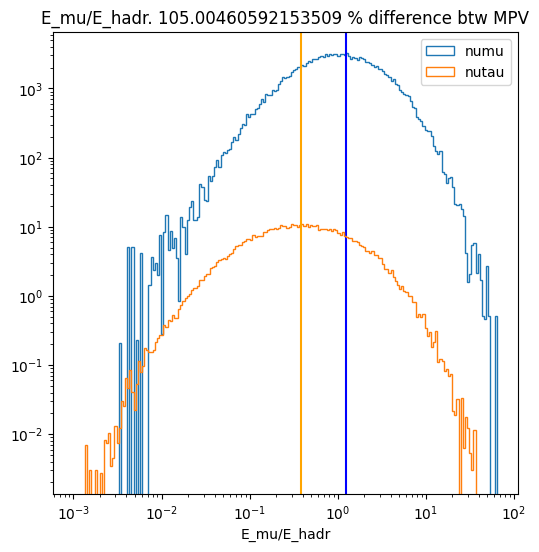

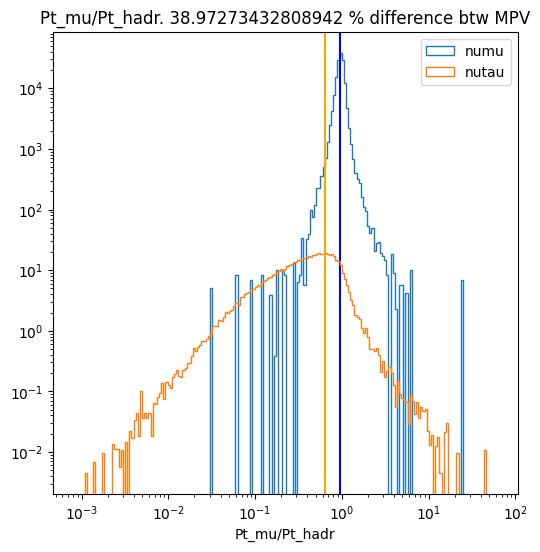

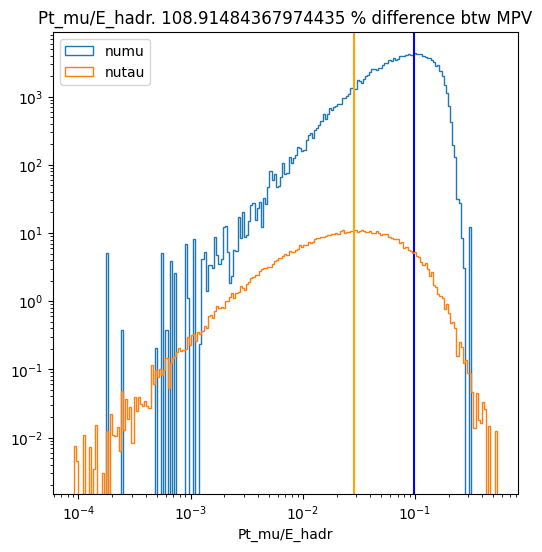

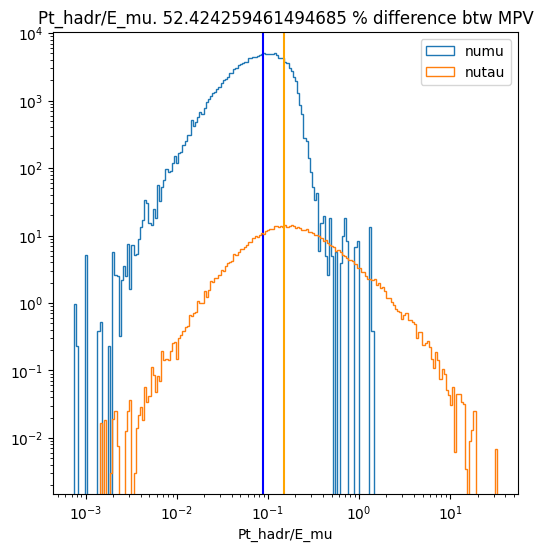

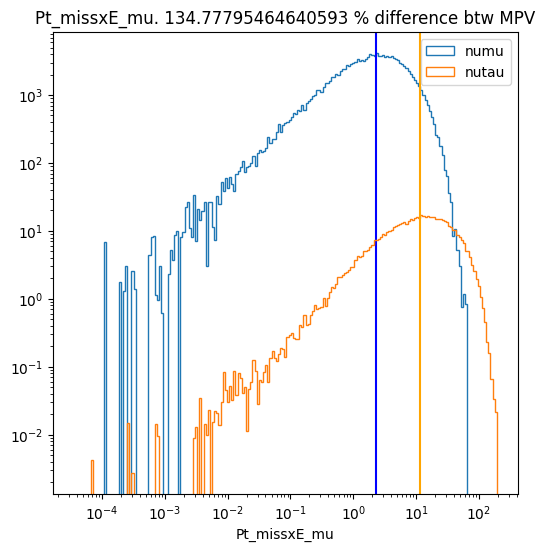

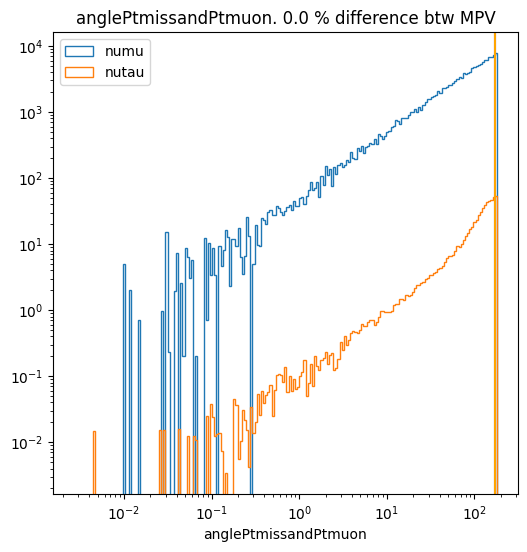

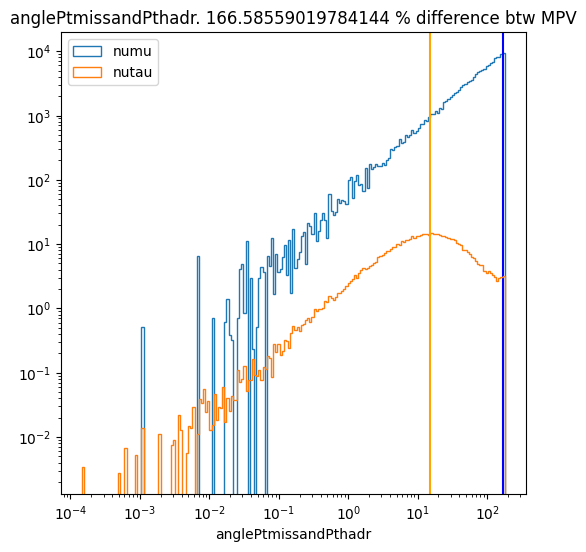

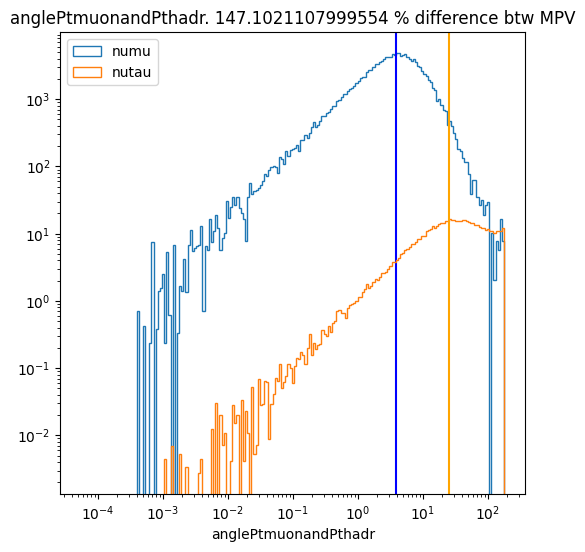

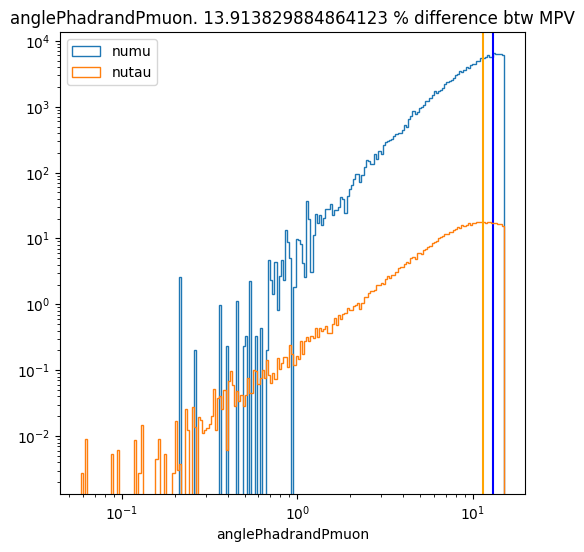

In [80]:
from sklearn.utils.extmath import weighted_mode

# list_of_interest = ["P_mu", "Energy_hadr", 'Energy_loss', 'anglebtwPmuandEhadr',
#        'Pt_miss', 'Pt_hadr', 'Pt_mu', 'Pt_miss/P_mu',
#        'Pt_miss/E_hadr', 'Pt_miss/Pt_mu', 'Pt_miss/Pt_hadr', 'P_mu/E_hadr',
#        'Pt_mu/Pt_hadr', 'anglebtwPtmissandPtmuon', 'anglebtwPtmissandPthadr',
#        'Pt_mu_on_Pt_miss']
list_of_interest = df_muon_1.drop(columns=['label', "weight_mu"]).columns
#list_of_interest = ['Pt_miss/Pt_mu', 'Pt_hadr/Pt_mu']
#bins = [np.linspace(0, 2000, 100), np.linspace(0, 4000, 100), np.linspace(0, 200, 100), np.linspace(0, 1., 100), np.linspace(0, 10., 100)]
ranges = []
# Data_conv = df_muon_1.loc[df_muon_1["Pt_miss/E_mu"] > 7.5]
Data_conv = df_muon_1
# Data_conv = df_muon_1.loc[df_muon_1["Pt_miss/Pt_mu"] > 55.0]
# Data_conv = df_muon_1.loc[df_muon_1["Pt_miss/E_mu"] > 2.5]
# Data_conv = df_muon_1.loc[df_muon_1['E_mu'] > 0.5]
Data_conv = df_muon_1.query("anglePhadrandPmuon < 15.")
nutau_events_number = len(Data_conv.query("label == 'nutau'")["E_mu"])
weighted_nutau_events_number = Data_conv.query("label == 'nutau'")["weight_mu"].sum()/df_muon_1.query("label == 'nutau'")["weight_mu"].sum()
print(f"Number of nutau events {nutau_events_number}, percentage: {weighted_nutau_events_number*100}%")



bad_params = []
good_params = []

for param in list_of_interest:
    min_mu, min_tau = min(Data_conv.query("label == 'numu'")[param]), min(Data_conv.query("label == 'nutau'")[param])
    max_mu, max_tau = max(Data_conv.query("label == 'numu'")[param]), max(Data_conv.query("label == 'nutau'")[param])
    print(f"{param}. Range for numu: [{min_mu} {max_mu}]")
    print(f"{param}. Range for nutau: [{min_tau} {max_tau}]")
    if (min_tau > max_mu and max_tau > max_mu) or (min_tau < min_mu and max_tau < min_mu):
        print("alarm")
        
    if max_tau < max_mu and min_tau > min_mu:
        print(f"{param} is a bad parameter")
        bad_params.append(param)
    ranges.append(f"[{min(Data_conv[param]):.2f} {max(Data_conv[param]):.2f}]")
    bins = np.logspace(np.log10(min(Data_conv[param])), np.log10(max(Data_conv[param])), 200)
    #bins = np.linspace(min(Data_conv[param]), max(Data_conv[param]), 200)
    fig, ax = plt.subplots(figsize = (6,6), dpi = 100)
    h_mu = ax.hist(Data_conv.query("label == 'numu'")[param], histtype = "step", 
            #density = True, 
            weights = Data_conv.query("label == 'numu'")["weight_mu"],
            bins = bins, label = "numu")
    #ax.axvline(weighted_mode(Data_conv.query("label == 'numu'")[param], Data_conv.query("label == 'numu'")["weight_mu"])[0][0], color = "red")
    ax.axvline(h_mu[1][np.argmax(h_mu[0])], color = "blue")
    
    h_tau = ax.hist(Data_conv.query("label == 'nutau'")[param], histtype = "step", 
            #density = True, 
            weights = Data_conv.query("label == 'nutau'")["weight_mu"],
            bins = bins, label = "nutau")  
#     ax.set_xlim([13.1,1e3])
    #ax.axvline(weighted_mode(Data_conv.query("label == 'nutau'")[param], Data_conv.query("label == 'nutau'")["weight_mu"])[0][0], color = "blue")
    ax.axvline(h_tau[1][np.argmax(h_tau[0])], color = "orange")
    av_point = (h_tau[1][np.argmax(h_tau[0])] + h_mu[1][np.argmax(h_mu[0])])/2
    diff_point = np.abs(h_tau[1][np.argmax(h_tau[0])] - h_mu[1][np.argmax(h_mu[0])])/av_point
    print(f"average point: {(h_tau[1][np.argmax(h_tau[0])] + h_mu[1][np.argmax(h_mu[0])])/2}, difference: {diff_point*100}")
    print(f"tau point: {h_tau[1][np.argmax(h_tau[0])]}")
    if diff_point*100 > 100:
        good_params.append(param)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(param)
    ax.set_title(param + f". {diff_point*100} % difference btw MPV")
    ax.legend()
    fig.savefig(f"pics/{param.replace('/', '_') if '/' in param else param}.pdf")

In [33]:
good_params

['Pt_miss',
 'Pt_miss/E_mu',
 'Pt_miss/E_hadr',
 'Pt_miss/Pt_mu',
 'Pt_miss/Pt_hadr',
 'E_mu/E_hadr',
 'E_mu/Pt_miss',
 'E_hadr/Pt_miss',
 'Pt_hadr/Pt_miss',
 'E_hadr/E_mu']

In [10]:
h_mu[1][np.argmax(h_mu[0])]

1.002978779108018

In [13]:
weighted_mode(Data_conv.query("label == 'numu'")[param], Data_conv.query("label == 'numu'")["weight_mu"])[0][0]

0.246434

In [6]:
bad_params

['px_mu',
 'py_mu',
 'pz_mu',
 'E_hadr',
 'Pt_miss',
 'Pt_hadr',
 'Pt_miss/E_hadr',
 'Pt_miss/Pt_hadr',
 'E_hadr/Pt_miss',
 'Pt_hadr/Pt_miss',
 'Pt_mu_on_Pt_miss']

In [10]:
len(df_muon_1.columns)

27

In [35]:
df_muon_1.loc[(df_muon_1["Pt_hadr/Pt_mu"] > 5.5) & (df_muon_1["Pt_hadr/Pt_mu"] < 10.)]

,px_mu,py_mu,pz_mu,E_mu,weight_mu,E_hadr,label,Pt_miss,Pt_hadr,Pt_mu,...,E_hadr/Pt_miss,Pt_hadr/Pt_miss,E_hadr/E_mu,Pt_hadr/Pt_mu,anglePtmissandPtmuon,anglePtmissandPthadr,anglePtmuonandPthadr,Pt_mu_on_Pt_miss,Pt_hadr_on_Pt_miss,anglePhadrandPmuon
991,0.222456,0.973896,5.224020,5.319730,10.000000,10.376008,numu,4.543621,5.542798,0.999177,...,2.283643,1.219908,1.950476,5.547364,0.614061,2.706627,2.962497,0.075890,-0.115144,0.750150
1457,0.211505,-0.048043,56.480100,56.480600,3.024684,2.063044,numu,1.108813,1.325706,0.216893,...,1.860588,1.195609,0.036527,6.112252,1.124447,2.724475,2.434263,0.029375,-0.138524,0.700805
2249,-0.083196,-1.054490,67.457000,67.465300,1.755399,25.521952,numu,4.948815,6.006582,1.057767,...,5.157185,1.213741,0.378297,5.678549,0.118163,3.068055,3.096967,0.136321,-0.219674,0.253243
2963,0.281117,-0.774142,1.090280,1.370470,10.000000,17.143837,numu,5.026149,5.852209,0.826060,...,3.410929,1.164353,12.509458,7.084483,1.010158,2.484946,2.788081,0.040696,-0.084099,0.980072
3332,-0.043723,-0.016900,0.550323,0.562331,8.193070,17.320610,numu,0.356083,0.403809,0.047726,...,48.642032,1.134029,30.801450,8.461055,0.019018,3.139195,3.124973,0.042768,-0.339282,0.108287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199940,-0.365192,0.186424,5.467092,5.483471,0.013890,22.881476,nutau,2.737583,3.147683,0.410100,...,8.358276,1.149804,4.172809,7.675403,0.002676,3.141206,3.139304,0.363078,-2.509681,0.212860
199961,0.080045,-1.117131,14.640904,14.684063,0.006249,70.166001,nutau,6.057943,7.177968,1.120025,...,11.582480,1.184885,4.778378,6.408758,0.145327,3.114159,3.023700,0.878527,-4.685745,0.178523
199962,-0.172659,0.414146,6.949988,6.965264,0.006249,70.644049,nutau,3.778194,4.226942,0.448748,...,18.697834,1.118773,10.142337,9.419417,0.099327,3.130188,3.053670,0.408277,-3.567514,0.124221
199976,-0.143189,0.136677,1.544951,1.561183,0.016373,7.479932,nutau,1.521866,1.720273,0.198407,...,4.914974,1.130371,4.791195,8.670439,2.191448,3.022976,1.068761,-0.110919,-1.301898,0.203487


In [23]:
df_muon_2.query("label == 'numu'")

,px_mu,py_mu,pz_mu,E_mu,weight_mu,E_hadr,label,Pt_miss,Pt_hadr,Pt_mu,...,E_hadr/Pt_miss,Pt_hadr/Pt_miss,E_hadr/E_mu,Pt_hadr/Pt_mu,anglePtmissandPtmuon,anglePtmissandPthadr,anglePtmuonandPthadr,Pt_mu_on_Pt_miss,Pt_hadr_on_Pt_miss,anglePhadrandPmuon
6250,-0.356380,0.248521,53.21120,53.21310,3.024684,9.740381,numu,6.580418,7.014895,0.434477,...,1.480207,1.066026,0.183045,16.145607,1.591651,2.562726,2.128809,-0.000928,-0.068047,0.808418
9064,0.009829,-0.140074,19.35070,19.35150,6.808881,5.226582,numu,2.811608,2.952029,0.140421,...,1.858930,1.049943,0.270087,21.022772,2.722431,2.995674,0.565080,-0.023591,-0.071524,0.594086
11189,0.049294,-0.339504,6.58767,6.59744,8.193070,27.192866,numu,5.916623,6.259731,0.343108,...,4.596011,1.057990,4.121730,18.244208,1.510768,2.932767,1.839650,0.005550,-0.435732,0.251070
11225,0.174061,-0.323856,3.93727,3.95581,8.193070,32.804393,numu,5.776484,6.144284,0.367799,...,5.678955,1.063672,8.292712,16.705529,0.728404,3.037233,2.517548,0.097956,-0.834270,0.269459
16672,0.357620,-0.005272,6.62667,6.63716,10.000000,9.705392,numu,6.284145,6.641849,0.357704,...,1.544425,1.056922,1.462281,18.567982,0.678656,2.761989,2.842540,0.012598,-0.025466,0.805359
21158,0.132262,0.244143,86.44440,86.44490,1.324653,8.795714,numu,3.856341,4.134009,0.277667,...,2.280844,1.072003,0.101749,14.888352,0.036150,3.125039,3.121996,0.023651,-0.051667,0.492505
22211,0.104696,0.160004,6.76675,6.77028,10.000000,2.979370,numu,2.354401,2.545638,0.191237,...,1.265447,1.081225,0.440066,13.311449,1.213166,2.785130,2.284890,0.011772,-0.084598,1.043074
27522,0.519605,0.213468,66.72780,66.73030,2.033576,16.583219,numu,6.986102,7.547848,0.561747,...,2.373744,1.080409,0.248511,13.436394,1.115975,2.748771,2.418439,0.034303,-0.169292,0.478882
42919,-0.447687,-0.194684,45.32750,45.33030,3.895732,12.813286,numu,8.804404,9.292592,0.488188,...,1.455327,1.055448,0.282665,19.034871,0.384804,3.010065,2.888317,0.047936,-0.146751,0.821799
45141,-0.042933,0.343109,91.34390,91.34460,0.970011,29.211445,numu,5.335920,5.681705,0.345785,...,5.474491,1.064803,0.319794,16.431330,2.244165,2.577100,1.461920,-0.025966,-0.051401,0.195375


Index(['px_mu', 'py_mu', 'pz_mu', 'E_mu', 'weight_mu', 'E_hadr', 'label',
       'Pt_miss', 'Pt_hadr', 'Pt_mu', 'Pt_miss/E_mu', 'Pt_miss/E_hadr',
       'Pt_miss/Pt_mu', 'Pt_miss/Pt_hadr', 'E_mu/E_hadr', 'Pt_mu/Pt_hadr',
       'Pt_mu/E_hadr', 'Pt_hadr/E_mu', 'Pt_missxE_mu', 'anglePtmissandPtmuon',
       'anglePtmissandPthadr', 'anglePtmuonandPthadr', 'anglePhadrandPmuon'],
      dtype='object')
Number of nutau events 100000, percentage: 100.0%, abs value: 916.4261645554895, before cuts: 916.4261645554895
Number of numu events 100000, percentage: 100.0%, abs value: 337717.4261848143, before cuts: 337717.4261848143
[LightGBM] [Info] Number of positive: 75044, number of negative: 74956
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000055 seconds, init for row-wise cost 0.013089 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019683 seconds.
You can set `force_col_wi

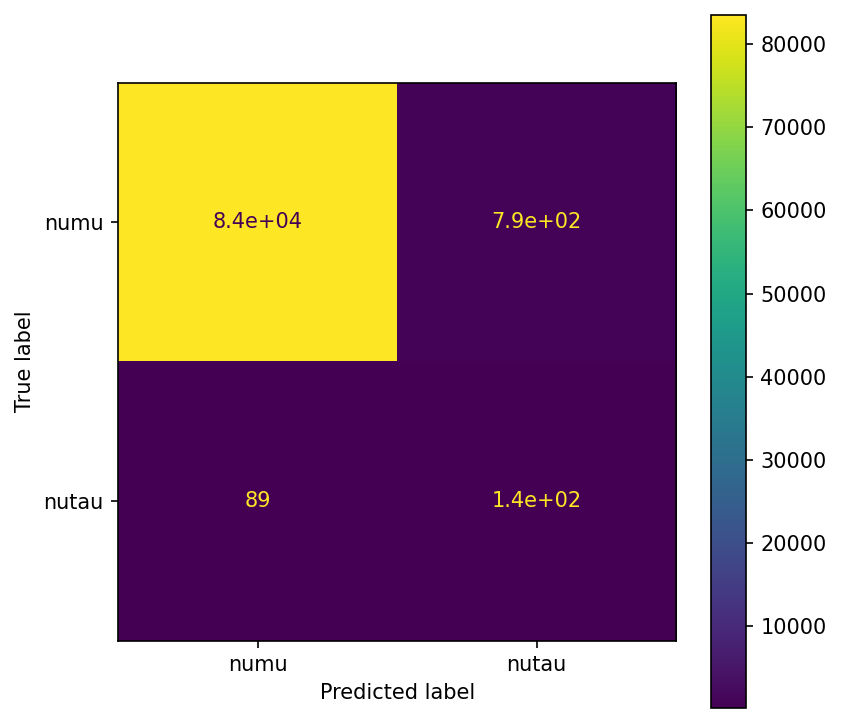

In [99]:
pca_num = 23
pca = PCA(n_components=pca_num).set_output(transform = "pandas")

preproc = pca
#X_pca = X
#X_pca = StandardScaler().fit_transform(X)

# X_smeared = smear_data(X)
# X_pca = preproc.fit_transform(X_smeared)


#df_muon_2 = df_muon_1.loc[(df_muon_1["Pt_miss/E_mu"] > 7.5) & (df_muon_1["Pt_hadr_on_Pt_miss"] < -1.5)]

# df_muon_2 = df_muon_1.loc[df_muon_1["Pt_miss/Pt_mu"] > 1e-4]


#df_muon_2 = df_muon_1.loc[:, ~df_muon_1.columns.isin(bad_params)]
#df_muon_2 = df_muon_1
#df_muon_2 = df_muon_1.loc[(df_muon_1["Pt_hadr/Pt_mu"] > 13.) & (df_muon_1["E_mu"] > 1.5)]

# df_muon_2 = df_muon_1.loc[(df_muon_1["Pt_hadr/Pt_mu"] > 13.) & (df_muon_1["E_mu"] > 1.5)]


#df_muon_2 = df_muon_1.loc[(df_muon_1["Pt_hadr/Pt_mu"] > 13.5) & (df_muon_1["E_mu"] > .5) & (df_muon_1["E_hadr"] > 1.0)]

df_muon_2 = df_muon_1
#df_muon_2 = df_muon_1.query("anglePhadrandPmuon < 15.")
print(df_muon_2.columns)


nutau_events_number = len(df_muon_2.query("label == 'nutau'")["E_mu"])
after_cuts = df_muon_2.query("label == 'nutau'")["weight_mu"].sum()
before_cuts = df_muon_1.query("label == 'nutau'")["weight_mu"].sum()
weighted_nutau_events_number = df_muon_2.query("label == 'nutau'")["weight_mu"].sum()/df_muon_1.query("label == 'nutau'")["weight_mu"].sum()

numu_events_number = len(df_muon_2.query("label == 'numu'")["E_mu"])
after_cuts_mu = df_muon_2.query("label == 'numu'")["weight_mu"].sum()
before_cuts_mu = df_muon_1.query("label == 'numu'")["weight_mu"].sum()
weighted_numu_events_number = df_muon_2.query("label == 'numu'")["weight_mu"].sum()/df_muon_1.query("label == 'numu'")["weight_mu"].sum()


print(f"Number of nutau events {nutau_events_number}, percentage: {weighted_nutau_events_number*100}%, abs value: {after_cuts}, before cuts: {before_cuts}")

print(f"Number of numu events {numu_events_number}, percentage: {weighted_numu_events_number*100}%, abs value: {after_cuts_mu}, before cuts: {before_cuts_mu}")


X = df_muon_2.drop(columns=['label', 'weight_mu']).values
y = df_muon_2["label"].map({'numu':0,'nutau':1}).values

X_pca = X
# X_pca = preproc.fit_transform(X)
X_pca = np.hstack((X_pca, df_muon_2['weight_mu'].values.reshape(-1, 1)))

# scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, df_muon_2["label"].map({'numu':0,'nutau':1}).values,  shuffle=True
)

# scaler = StandardScaler()

weights_train = X_train[:,-1]
X_train = X_train[:,:-1]
#X_train = preproc.fit_transform(X_train[:,:-1])

# X_train = scaler.fit_transform(X_train[:,:-1])
#rf = RandomForestClassifier()
rf = lightgbm.LGBMClassifier(boosting_type = "gbdt", objective='binary', metric='binary_logloss', verbose=2, 
                       # max_depth=-1, 
                       # n_estimators=1, 
                       # num_leaves = 31
                            )
rf.fit(X_train, y_train,
       sample_weight = weights_train,
       # feature_name=[f"PC {i}" for i in range(1,pca_num+1)]
       #feature_name = list(X.columns)
      )

# print(cross_val_score(rf, X_train, y_train, cv=5, 
#                           scoring = "f1", 
#                           fit_params={'sample_weight': weights_train}))

weights_test = X_test[:,-1]
X_test = X_test[:,:-1]

y_pred = rf.predict(X_test)

# X_test = pd.DataFrame(X_test)
# X_test.columns = X.columns
# X_test = smear_data(X_test).to_numpy()
# X_test = preproc.fit_transform(X_test[:,:-1])
# X_test = scaler.fit_transform(X_test[:,:-1])

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.rcParams.update({'font.size': 10})
# Assuming y_test and y_pred are your target and predicted labels, and weights_test are your sample weights
cm = confusion_matrix(y_test, y_pred, 
                      sample_weight=weights_test
                     )
print(cm)
#print(cm.sum(axis=0)[:, np.newaxis])
#cm = cm / cm.sum(axis=1)[:, np.newaxis] * 100
# Define the tick labels
tick_labels = ["numu", "nutau"]

# Create the plot

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
display = ConfusionMatrixDisplay(confusion_matrix=cm)


# Plot the confusion matrix
display.plot(ax=ax)

# Set tick labels
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)
fig.savefig("conf_matrix_labeled.pdf")

print(classification_report(y_test, y_pred, 
                            sample_weight = weights_test
                           )
     )


plt.show()

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, plot_metric

df_muon_2 = df_muon_1
#df_muon_2 = df_muon_1.query("Pt_miss > 2.")
print(df_muon_2.columns)


nutau_events_number = len(df_muon_2.query("label == 'nutau'")["E_mu"])
after_cuts = df_muon_2.query("label == 'nutau'")["weight_mu"].sum()
before_cuts = df_muon_1.query("label == 'nutau'")["weight_mu"].sum()
weighted_nutau_events_number = df_muon_2.query("label == 'nutau'")["weight_mu"].sum()/df_muon_1.query("label == 'nutau'")["weight_mu"].sum()

numu_events_number = len(df_muon_2.query("label == 'numu'")["E_mu"])
after_cuts_mu = df_muon_2.query("label == 'numu'")["weight_mu"].sum()
before_cuts_mu = df_muon_1.query("label == 'numu'")["weight_mu"].sum()
weighted_numu_events_number = df_muon_2.query("label == 'numu'")["weight_mu"].sum()/df_muon_1.query("label == 'numu'")["weight_mu"].sum()


print(f"Number of nutau events {nutau_events_number}, percentage: {weighted_nutau_events_number*100}%, abs value: {after_cuts}, before cuts: {before_cuts}")

print(f"Number of numu events {numu_events_number}, percentage: {weighted_numu_events_number*100}%, abs value: {after_cuts_mu}, before cuts: {before_cuts_mu}")


X = df_muon_2.drop(columns=['label', 'weight_mu']).values
y = df_muon_2["label"].map({'numu':0,'nutau':1}).values

X_pca = X
# X_pca = preproc.fit_transform(X)
X_pca = np.hstack((X_pca, df_muon_2['weight_mu'].values.reshape(-1, 1)))

# scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, df_muon_2["label"].map({'numu':0,'nutau':1}).values, random_state=13,  shuffle=True
)
# Initialize the LightGBM classifier
model = LGBMClassifier(objective='binary', metric='binary_logloss', verbose=1)


weights_train = X_train[:,-1]
X_train = X_train[:,:-1]
weights_test = X_test[:,-1]
X_test = X_test[:,:-1]



# Train the model while keeping track of the training progress
evals_result = {}
model.fit(
    X_train, y_train, sample_weight = weights_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_sample_weight=[weights_train, weights_test],
    eval_names=['train', 'valid'],
    eval_metric='binary_logloss',
    callbacks=[plot_metric(evals_result, metric='binary_logloss')],
    verbose=10
)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['binary_logloss'], label='Train Loss')
plt.plot(evals_result['valid']['binary_logloss'], label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Training Loss and Validation Loss over Iterations')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred, sample_weight=weights_test))
print('Classification Report:\n', classification_report(y_test, y_pred, sample_weight=weights_test))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred, sample_weight=weights_test))


Index(['px_mu', 'py_mu', 'pz_mu', 'E_mu', 'weight_mu', 'E_hadr', 'label',
       'Pt_miss', 'Pt_hadr', 'Pt_mu', 'Pt_miss/E_mu', 'Pt_miss/E_hadr',
       'Pt_miss/Pt_mu', 'Pt_miss/Pt_hadr', 'E_mu/E_hadr', 'Pt_mu/Pt_hadr',
       'Pt_mu/E_hadr', 'Pt_hadr/E_mu', 'Pt_missxE_mu', 'anglePtmissandPtmuon',
       'anglePtmissandPthadr', 'anglePtmuonandPthadr', 'anglePhadrandPmuon'],
      dtype='object')
Number of nutau events 100000, percentage: 100.0%, abs value: 916.4261645554895, before cuts: 916.4261645554895
Number of numu events 100000, percentage: 100.0%, abs value: 337717.4261848143, before cuts: 337717.4261848143


ValueError: eval results cannot be empty.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from lightgbm.callback import record_evaluation
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

#df_muon_2 = df_muon_1
df_muon_2 = df_muon_1.query("anglePhadrandPmuon < 15.")
print(df_muon_2.columns)


nutau_events_number = len(df_muon_2.query("label == 'nutau'")["E_mu"])
after_cuts = df_muon_2.query("label == 'nutau'")["weight_mu"].sum()
before_cuts = df_muon_1.query("label == 'nutau'")["weight_mu"].sum()
weighted_nutau_events_number = df_muon_2.query("label == 'nutau'")["weight_mu"].sum()/df_muon_1.query("label == 'nutau'")["weight_mu"].sum()

numu_events_number = len(df_muon_2.query("label == 'numu'")["E_mu"])
after_cuts_mu = df_muon_2.query("label == 'numu'")["weight_mu"].sum()
before_cuts_mu = df_muon_1.query("label == 'numu'")["weight_mu"].sum()
weighted_numu_events_number = df_muon_2.query("label == 'numu'")["weight_mu"].sum()/df_muon_1.query("label == 'numu'")["weight_mu"].sum()


print(f"Number of nutau events {nutau_events_number}, percentage: {weighted_nutau_events_number*100}%, abs value: {after_cuts}, before cuts: {before_cuts}")

print(f"Number of numu events {numu_events_number}, percentage: {weighted_numu_events_number*100}%, abs value: {after_cuts_mu}, before cuts: {before_cuts_mu}")


X = df_muon_2.drop(columns=['label', 'weight_mu']).values
y = df_muon_2["label"].map({'numu':0,'nutau':1}).values

X_pca = X
# X_pca = preproc.fit_transform(X)
X_pca = np.hstack((X_pca, df_muon_2['weight_mu'].values.reshape(-1, 1)))

# scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, df_muon_2["label"].map({'numu':0,'nutau':1}).values, 
    #random_state=13,  
    shuffle=True
)


w_train = X_train[:,-1]
X_train = X_train[:,:-1]
w_test = X_test[:,-1]
X_test = X_test[:,:-1]



# Initialize the LightGBM classifier
model = LGBMClassifier(boosting_type = "gbdt", objective='binary', metric='binary_logloss', verbose=2, 
                       max_depth=-1, 
                       n_estimators=1, 
                       num_leaves = 31
                      )
#model = LGBMClassifier()
#model = AdaBoostClassifier()
# Prepare to record the evaluation results
evals_result = {}

# Train the model while keeping track of the training progress
model.fit(
    X_train, y_train,
    sample_weight=w_train,
    # eval_set=[(X_train, y_train), (X_test, y_test)],
    # eval_sample_weight=[w_train, w_test],
    # eval_names=['train', 'valid'],
    # eval_metric='binary_logloss',
    # callbacks=[record_evaluation(evals_result)],
)

# Plot the training loss
# plt.figure(figsize=(10, 6))
# plt.plot(evals_result['train']['binary_logloss'], label='Train Loss')
# plt.plot(evals_result['valid']['binary_logloss'], label='Validation Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Log Loss')
# plt.title('Training Loss and Validation Loss over Iterations')
# plt.legend()
# plt.show()

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred, sample_weight = w_test))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred, sample_weight = w_test))


# f1 score. Bootstrap
def bootstrap_metric(x, 
                     y,
                     w,
                     metric_fn,
                     samples_cnt = 200,
                     alpha = 0.05,
                     random_state = 42):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        w_boot = w[poses]
        
        m_val = metric_fn(x_boot, y_boot, w_boot)
        b_metric[it] = m_val
        if it%50 == 0:
            print(it, "times...")
    
    return b_metric
alpha = 0.05


def my_metric(y_true, y_pred, sample_weight):
    conf_mat = confusion_matrix(y_true, y_pred, sample_weight = sample_weight)
    return conf_mat[1][1]/(conf_mat[0][1] + conf_mat[1][0])
# y_pred = rf.predict(X_test)
# cor = accuracy_score(y_test, y_pred)
# print(f1_score(y_true=y_test, y_pred=y_pred))
boot_mat_score = bootstrap_metric(y_test, y_pred, w_test, metric_fn=lambda x, y, w: f1_score(y_true=x, y_pred=y, sample_weight=w) , alpha = alpha)
print("Model: {0}".format("BDT"), " \t f1-score: ", np.quantile(boot_mat_score, q=[alpha/2, 1 - alpha/2]))
boot_mat_score = bootstrap_metric(y_test, y_pred, w_test, metric_fn=lambda x, y, w: precision_score(y_true=x, y_pred=y, sample_weight=w) , alpha = alpha)
print("Model: {0}".format("BDT"), " \t precision-score: ", np.quantile(boot_mat_score, q=[alpha/2, 1 - alpha/2]))
boot_mat_score = bootstrap_metric(y_test, y_pred, w_test, metric_fn=lambda x, y, w: recall_score(y_true=x, y_pred=y, sample_weight=w) , alpha = alpha)
print("Model: {0}".format("BDT"), " \t recall-score: ", np.quantile(boot_mat_score, q=[alpha/2, 1 - alpha/2]))

boot_mat_score = bootstrap_metric(y_test, y_pred, w_test, metric_fn=lambda x, y, w: my_metric(y_true=x, y_pred=y, sample_weight=w) , alpha = alpha)
print("Model: {0}".format("BDT"), " \t signal_noise-score: ", np.quantile(boot_mat_score, q=[alpha/2, 1 - alpha/2]))



conf_mat = confusion_matrix(y_test, y_pred, sample_weight = w_test)
my_metric = (conf_mat[0][1] + conf_mat[1][0])/conf_mat[1][1]
print(my_metric)


Index(['px_mu', 'py_mu', 'pz_mu', 'E_mu', 'weight_mu', 'E_hadr', 'label',
       'Pt_miss', 'Pt_hadr', 'Pt_mu', 'Pt_miss/E_mu', 'Pt_miss/E_hadr',
       'Pt_miss/Pt_mu', 'Pt_miss/Pt_hadr', 'E_mu/E_hadr', 'Pt_mu/Pt_hadr',
       'Pt_mu/E_hadr', 'Pt_hadr/E_mu', 'Pt_missxE_mu', 'anglePtmissandPtmuon',
       'anglePtmissandPthadr', 'anglePtmuonandPthadr', 'anglePhadrandPmuon'],
      dtype='object')
Number of nutau events 75745, percentage: 70.14082637840207%, abs value: 642.7888849671151, before cuts: 916.4261645554895
Number of numu events 62634, percentage: 45.2511068881775%, abs value: 152820.8735028923, before cuts: 337717.4261848143
[LightGBM] [Info] Number of positive: 56778, number of negative: 47006
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000019 seconds, init for row-wise cost 0.002882 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004726 seconds.
You 

In [13]:
def prepare_formula(var, top_three_values_pc):
    var_names = list(map(str, top_three_values_pc.index))
    var_vals = top_three_values_pc.to_numpy()
    output_str = var + "="
    k = 0
    for val, name in zip(var_vals, var_names):
        output_str += f"{val:.2f}*{name}"
        if k != 2:
            output_str += "+"
        k += 1 
    return output_str

par1 = "PC 5"
par2 = "PC 6"
par3 = "PC 2"
par4 = "PC 7"

loadings = pd.DataFrame(pca.components_.T, columns=[f'PC {i + 1}' for i in range(pca.n_components_)], index=df_muon_2.drop(columns=['label', 'weight_mu']).columns)
top_three_values_pc1 = loadings.nlargest(3, par1)[par1]
top_three_values_pc2 = loadings.nlargest(3, par2)[par2]
top_three_values_pc3 = loadings.nlargest(3, par3)[par3]
top_three_values_pc4 = loadings.nlargest(3, par4)[par4]

print(top_three_values_pc1, "\n", top_three_values_pc2, "\n", top_three_values_pc3, "\n", top_three_values_pc4)
str_out = prepare_formula(par1, top_three_values_pc1) + "\n" + prepare_formula(par2, top_three_values_pc2) + "\n" + \
             prepare_formula(par3, top_three_values_pc3) + "\n" + prepare_formula(par4, top_three_values_pc4)
str_out

E_hadr/E_mu      0.458413
E_hadr           0.415424
Pt_miss/Pt_mu    0.051683
Name: PC 5, dtype: float64 
 Pt_hadr/Pt_miss    0.007244
Pt_hadr/Pt_mu      0.001494
Pt_miss/Pt_mu      0.001442
Name: PC 6, dtype: float64 
 E_hadr/Pt_miss      0.788913
Pt_mu_on_Pt_miss    0.000204
E_hadr              0.000106
Name: PC 2, dtype: float64 
 E_hadr         0.592867
E_hadr/E_mu    0.510094
E_mu           0.435410
Name: PC 7, dtype: float64


'PC 5=0.46*E_hadr/E_mu+0.42*E_hadr+0.05*Pt_miss/Pt_mu\nPC 6=0.01*Pt_hadr/Pt_miss+0.00*Pt_hadr/Pt_mu+0.00*Pt_miss/Pt_mu\nPC 2=0.79*E_hadr/Pt_miss+0.00*Pt_mu_on_Pt_miss+0.00*E_hadr\nPC 7=0.59*E_hadr+0.51*E_hadr/E_mu+0.44*E_mu'

NameError: name 'rf' is not defined

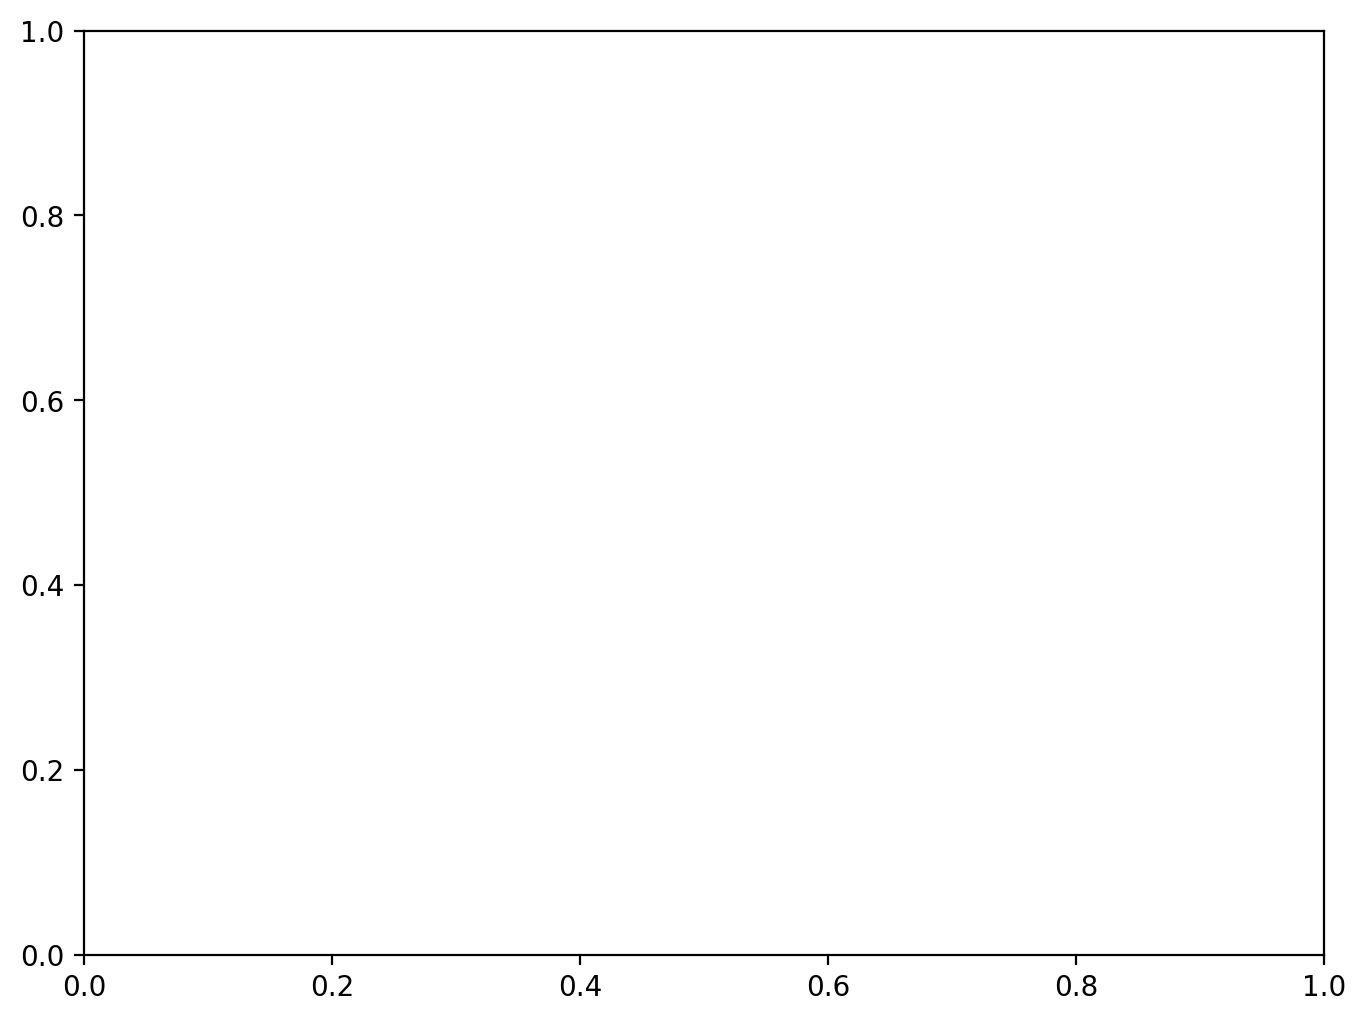

In [14]:
# Plot feature importance using Gain
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
lightgbm.plot_importance(rf, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)", max_num_features=23, ax = ax)
def prepare_formula(var, top_three_values_pc):
    var_names = list(map(str, top_three_values_pc.index))
    var_vals = top_three_values_pc.to_numpy()
    output_str = var + "="
    k = 0
    for val, name in zip(var_vals, var_names):
        output_str += f"{val:.2f}*{name}"
        if k != 2:
            output_str += "+"
        k += 1 
    return output_str
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC {i + 1}' for i in range(pca.n_components_)], index=df_muon_2.drop(columns=['label', 'weight_mu']).columns)
par1 = "PC 3"
par2 = "PC 5"
par3 = "PC 13"
par4 = "PC 8"
top_three_values_pc1 = loadings.nlargest(3, par1)[par1]
top_three_values_pc2 = loadings.nlargest(3, par2)[par2]
top_three_values_pc3 = loadings.nlargest(3, par3)[par3]
top_three_values_pc4 = loadings.nlargest(3, par4)[par4]
print(top_three_values_pc1, "\n", top_three_values_pc2, "\n", top_three_values_pc3, "\n", top_three_values_pc4)
str_out = prepare_formula(par1, top_three_values_pc1) + "\n" + prepare_formula(par2, top_three_values_pc2) + "\n" + \
             prepare_formula(par3, top_three_values_pc3) + "\n" + prepare_formula(par4, top_three_values_pc4)


ax.text(0.15, 0.05, str_out, transform=ax.transAxes, fontsize=11, verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

fig.savefig("importance.pdf")
fig.show()

In [17]:
loadings

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,...,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23
px_mu,4.734653e-08,-1.078415e-07,4.494393e-07,0.000090,-0.000098,-0.000193,0.000114,-0.000043,0.000061,-2.117421e-03,...,-0.011779,3.624611e-03,2.667759e-04,2.810951e-04,-1.030653e-04,-2.872367e-04,-1.098751e-04,6.020465e-05,-8.985232e-06,2.519672e-05
py_mu,-2.525785e-07,-3.318184e-07,-1.068487e-06,-0.000012,0.000014,-0.000013,0.000053,-0.000101,-0.000013,-1.157073e-03,...,-0.019729,-8.215469e-04,1.394195e-03,7.316806e-04,-7.554937e-05,-1.161804e-04,-1.032464e-05,8.890923e-05,4.535729e-05,-4.494967e-06
pz_mu,1.132572e-05,-6.421025e-05,6.852403e-04,0.003162,-0.551898,-0.028220,0.435300,0.046334,0.042552,-3.181812e-02,...,-0.044475,-1.626869e-02,8.747482e-03,6.707255e-03,-5.142554e-03,2.804510e-02,1.337717e-01,1.623926e-02,3.158082e-01,-1.092019e-01
E_mu,1.135130e-05,-6.396502e-05,6.843489e-04,0.003174,-0.551298,-0.028315,0.435410,0.045705,0.041063,-3.585352e-02,...,0.006922,8.858539e-03,-4.177972e-03,-4.729312e-03,4.117757e-03,-2.870281e-02,-1.382952e-01,-1.612272e-02,-3.163626e-01,1.093674e-01
E_hadr,6.546647e-06,1.063454e-04,4.126890e-04,-0.005748,0.415424,-0.062156,0.592867,-0.684315,0.046247,3.876381e-02,...,-0.007133,-3.420518e-03,3.251064e-03,-1.974116e-03,-1.191684e-03,4.711582e-04,-2.637643e-03,2.633434e-04,7.252908e-04,-1.087116e-04
Pt_miss,-8.423347e-07,-1.627467e-06,-2.430752e-05,-0.000329,0.006307,0.000680,-0.002935,0.000714,0.031380,-2.743790e-02,...,-0.086228,-4.650638e-01,1.519558e-01,3.093200e-01,1.852974e-02,-2.377812e-01,3.017304e-02,-3.723873e-01,-5.067431e-02,3.859617e-01
Pt_hadr,-1.401725e-07,-1.140644e-06,-1.690200e-05,-0.000088,-0.004595,-0.000813,0.008656,-0.010760,0.021000,-1.417169e-01,...,0.550125,-1.684195e-01,-1.382035e-01,1.029547e-02,-1.534311e-02,2.366998e-02,9.646477e-03,4.221701e-01,3.851044e-02,-3.758720e-01
Pt_mu,6.742445e-07,4.463220e-07,6.807708e-06,0.000258,-0.010924,-0.001584,0.011878,-0.012034,-0.011304,-1.132030e-01,...,0.652404,2.432892e-01,-2.411754e-01,-2.527139e-01,1.167200e-01,7.837045e-02,3.783392e-02,-4.644921e-01,-2.575336e-02,3.552722e-01
Pt_miss/E_mu,-1.999782e-07,-3.530420e-07,-5.778667e-06,-0.000081,0.009411,-0.000643,0.005606,0.016299,0.019248,-1.361241e-02,...,0.020236,-1.610379e-01,6.482553e-01,-7.356809e-01,2.797146e-02,-7.092249e-03,-1.453436e-02,2.467750e-03,2.942559e-03,-2.503032e-03
Pt_miss/E_hadr,-4.090281e-08,-8.717453e-08,-1.179191e-06,-0.000011,-0.000219,0.000084,-0.000832,0.000837,0.001154,5.514227e-03,...,-0.005487,-1.738711e-02,-6.124052e-03,7.205542e-03,1.460776e-03,5.326189e-02,-1.478665e-01,-8.923109e-02,8.865381e-01,1.134170e-01


In [34]:
good_params

['Pt_miss',
 'Pt_miss/E_mu',
 'Pt_miss/E_hadr',
 'Pt_miss/Pt_mu',
 'Pt_miss/Pt_hadr',
 'E_mu/E_hadr',
 'E_mu/Pt_miss',
 'E_hadr/Pt_miss',
 'Pt_hadr/Pt_miss',
 'E_hadr/E_mu']

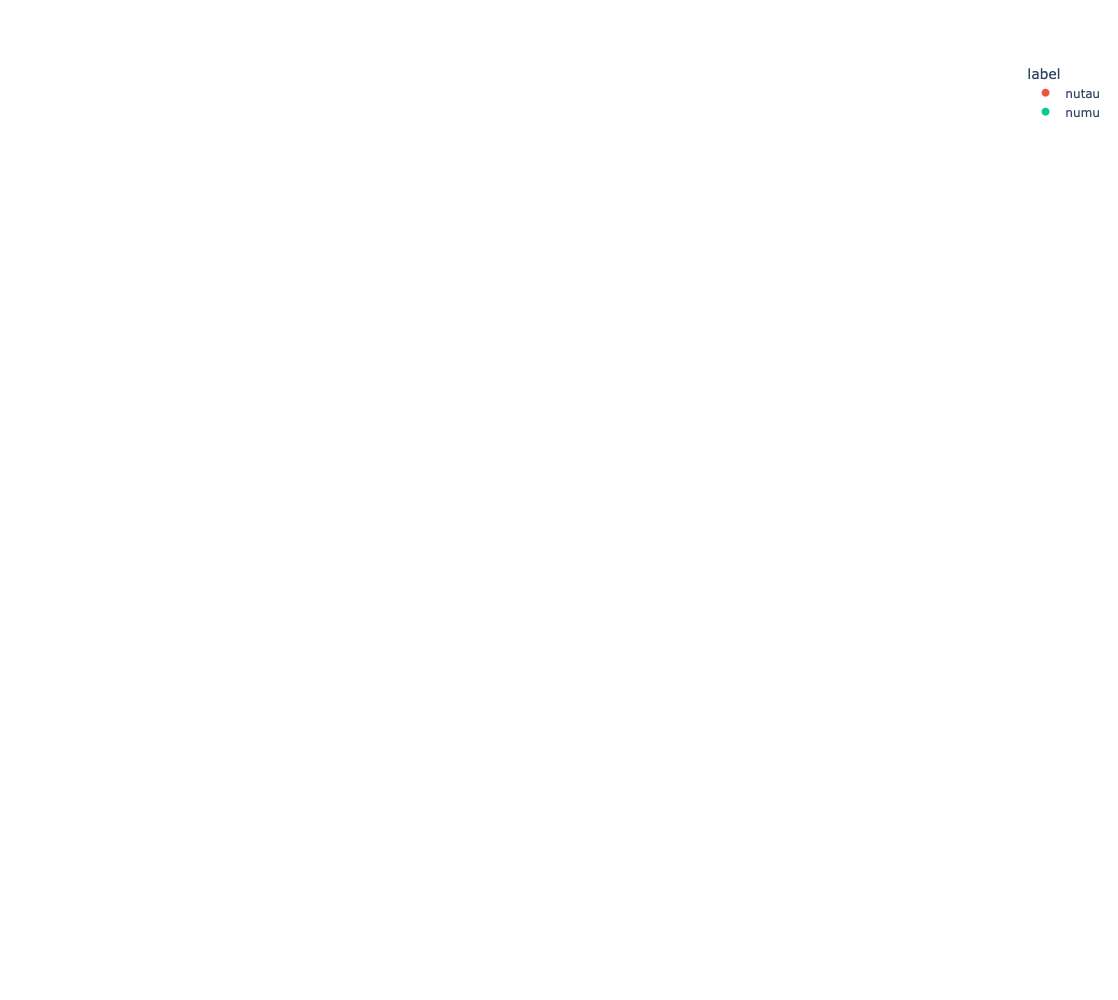

In [41]:
import plotly.express as px
X_df = pd.DataFrame(X_pca)
X_df.columns = df_muon_2.drop(columns=['label']).columns

X_train, X_test, y_train, y_test = train_test_split(
    X_df.loc[:,~X_df.columns.isin(["weight_mu"])], df_muon_2["label"].values, random_state=13,  shuffle=True, train_size = 0.05
)
# par1 = "PC 3"
# par2 = "PC 5"
# par3 = "PC 13"
par1 = 'Pt_miss/E_mu'
par2 = 'Pt_miss/Pt_mu'
par3 = 'E_hadr/E_mu'
scaleFactor = np.array([10]*len(y_train))
marker_size = scaleFactor  # You can adjust scaleFactor to control the marker size
symbol_mapping = {value: symbol for value, symbol in zip(np.unique(y_train), ["square", "circle"])}
marker_symbol = [symbol_mapping[value] for value in y_train]


X_df = pd.DataFrame(X_train)
X_df.columns = df_muon_2.drop(columns=['label', 'weight_mu']).columns
X_df["label"] = pd.Series(y_train)


fig = px.scatter_3d(X_df, x=par1, y=par2, z=par3, color="label")
                    #color=y_train, size=marker_size, symbol=marker_symbol)

# label_mapping = {value: label for value, label in zip(y_train.unique(), y_train.unique())}
# trace_name = [label_mapping[value] for value in y_train]
fig.update_layout(
    height=1000,  # set the height in pixels
    width=1000,   # set the width in pixels
    scene=dict(
        xaxis_title=par1,
        yaxis_title=par2,
        zaxis_title=par3,
#         xaxis=dict(range=[-50, 100]),
#         yaxis=dict(range=[-500, 500]),
#         zaxis=dict(range=[-50, 50])
    )
)
fig.write_html("3pca.html")
fig.show()



In [116]:
def cut_study(df_muon_1, param, cut_value_list):
    precision_list, recall_list, f1_list, number_of_tau_neutrinos, number_of_mu_neutrinos = [], [], [], [], []
    for cut_value in cut_value_list:
        #print(cut_value, cut_value_list)
        pca_num = 23
        pca = PCA(n_components=pca_num).set_output(transform = "pandas")
        preproc = pca
        #X_pca = X
        #X_pca = StandardScaler().fit_transform(X)
        # X_pca = preproc.fit_transform(X)
        # X_smeared = smear_data(X)
        # X_pca = preproc.fit_transform(X_smeared)
        #df_muon_2 = df_muon_1.loc[(df_muon_1["Pt_miss/E_mu"] > 7.5) & (df_muon_1["Pt_hadr_on_Pt_miss"] < -1.5)]

        df_muon_2 = df_muon_1.loc[df_muon_1[param] > cut_value]
        #print(df_muon_2)

        #df_muon_2 = df_muon_1.loc[:, ~df_muon_1.columns.isin(bad_params)]
        #df_muon_2 = df_muon_1
        # df_muon_2 = df_muon_1.loc[df_muon_1["Pt_miss/E_mu"] > 2.0]
        #print(df_muon_2.columns)
        #df_muon_2 = df_muon_1

        nutau_events_number = len(df_muon_2.query("label == 'nutau'")["E_mu"])
        weighted_nutau_events_number = df_muon_2.query("label == 'nutau'")["weight_mu"].sum()/df_muon_1.query("label == 'nutau'")["weight_mu"].sum()
        weighted_numu_events_number = df_muon_2.query("label == 'numu'")["weight_mu"].sum()/df_muon_1.query("label == 'numu'")["weight_mu"].sum()
        
        print(f"Number of nutau events {nutau_events_number}, percentage tau: {weighted_nutau_events_number*100}%, percentage tau: {weighted_numu_events_number*100}%")
        number_of_tau_neutrinos.append(weighted_nutau_events_number)
        number_of_mu_neutrinos.append(weighted_numu_events_number)


        X = df_muon_2.drop(columns=['label', 'weight_mu']).values
        y = df_muon_2["label"].map({'numu':0,'nutau':1}).values

        X_pca = X
        X_pca = np.hstack((X_pca, df_muon_2['weight_mu'].values.reshape(-1, 1)))

        # scaler = StandardScaler()

        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, df_muon_2["label"].map({'numu':0,'nutau':1}).values, random_state=13,  shuffle=True
        )

        # scaler = StandardScaler()

        weights_train = X_train[:,-1]
        X_train = X_train[:,:-1]
        #X_train = preproc.fit_transform(X_train[:,:-1])

        # X_train = scaler.fit_transform(X_train[:,:-1])
        #rf = RandomForestClassifier()
        rf = lightgbm.LGBMClassifier(verbosity=-1)
        rf.fit(X_train, y_train,
               sample_weight = weights_train,
               # feature_name=[f"PC {i}" for i in range(1,pca_num+1)]
               #feature_name = list(X.columns)
              )
        weights_test = X_test[:,-1]
        X_test = X_test[:,:-1]

        y_pred = rf.predict(X_test)
        
        precision_list.append(precision_score(y_test, y_pred, sample_weight = weights_test))
        recall_list.append(recall_score(y_test, y_pred, sample_weight = weights_test))
        f1_list.append(f1_score(y_true=y_test, y_pred=y_pred, sample_weight=weights_test))
        
    return precision_list, recall_list, f1_list, number_of_tau_neutrinos, number_of_mu_neutrinos
        # X_test = pd.DataFrame(X_test)
        # X_test.columns = X.columns
        # X_test = smear_data(X_test).to_numpy()
        # X_test = preproc.fit_transform(X_test[:,:-1])
        # X_test = scaler.fit_transform(X_test[:,:-1])
        #print(classification_report(y_test, y_pred, sample_weight = weights_test))

In [99]:
param = "Pt_miss/Pt_mu"

In [118]:
# cut_value_list = [i*0.10 for i in range(0, 100, 2)]
# param = "Pt_miss/Pt_mu"

# cut_value_list = [10 + i*0.10 for i in range(50)]
# # # cut_value_list = [0.025]
# param = "Pt_hadr/Pt_mu"



cut_value_list = [i*0.10 for i in range(25)]
# cut_value_list = [0.025]
param = "Pt_miss"
precision_list, recall_list, f1_list, number_of_tau_neutrinos, number_of_mu_neutrinos = cut_study(df_muon_1, param, cut_value_list)



#precision_list, recall_list, f1_list, number_of_tau_neutrinos = cut_study(df_muon_1, param, cut_value_list)


Number of nutau events 100000, percentage tau: 100.0%, percentage tau: 100.0%
Number of nutau events 99535, percentage tau: 99.49070412885884%, percentage tau: 89.81317259679817%
Number of nutau events 98163, percentage tau: 97.98762434792198%, percentage tau: 64.38624143807806%
Number of nutau events 95943, percentage tau: 95.5325188113459%, percentage tau: 42.657696188824744%
Number of nutau events 93083, percentage tau: 92.34269198294315%, percentage tau: 28.984024583700453%
Number of nutau events 89632, percentage tau: 88.58643785118078%, percentage tau: 19.14258921654014%
Number of nutau events 85801, percentage tau: 84.33884625812597%, percentage tau: 12.308764050186648%
Number of nutau events 81584, percentage tau: 79.6726190043821%, percentage tau: 7.850931597118358%
Number of nutau events 77198, percentage tau: 74.8688333771031%, percentage tau: 4.892202264512316%
Number of nutau events 72640, percentage tau: 69.85741870943424%, percentage tau: 3.144479203262198%
Number of nut

In [48]:
precision_list

[0.6504123633739954]

Pt_miss. Range for numu: [0.0003930502766821681 2.8478681505793193]
Pt_miss. Range for nutau: [0.005076785805419928 6.853766517487297]


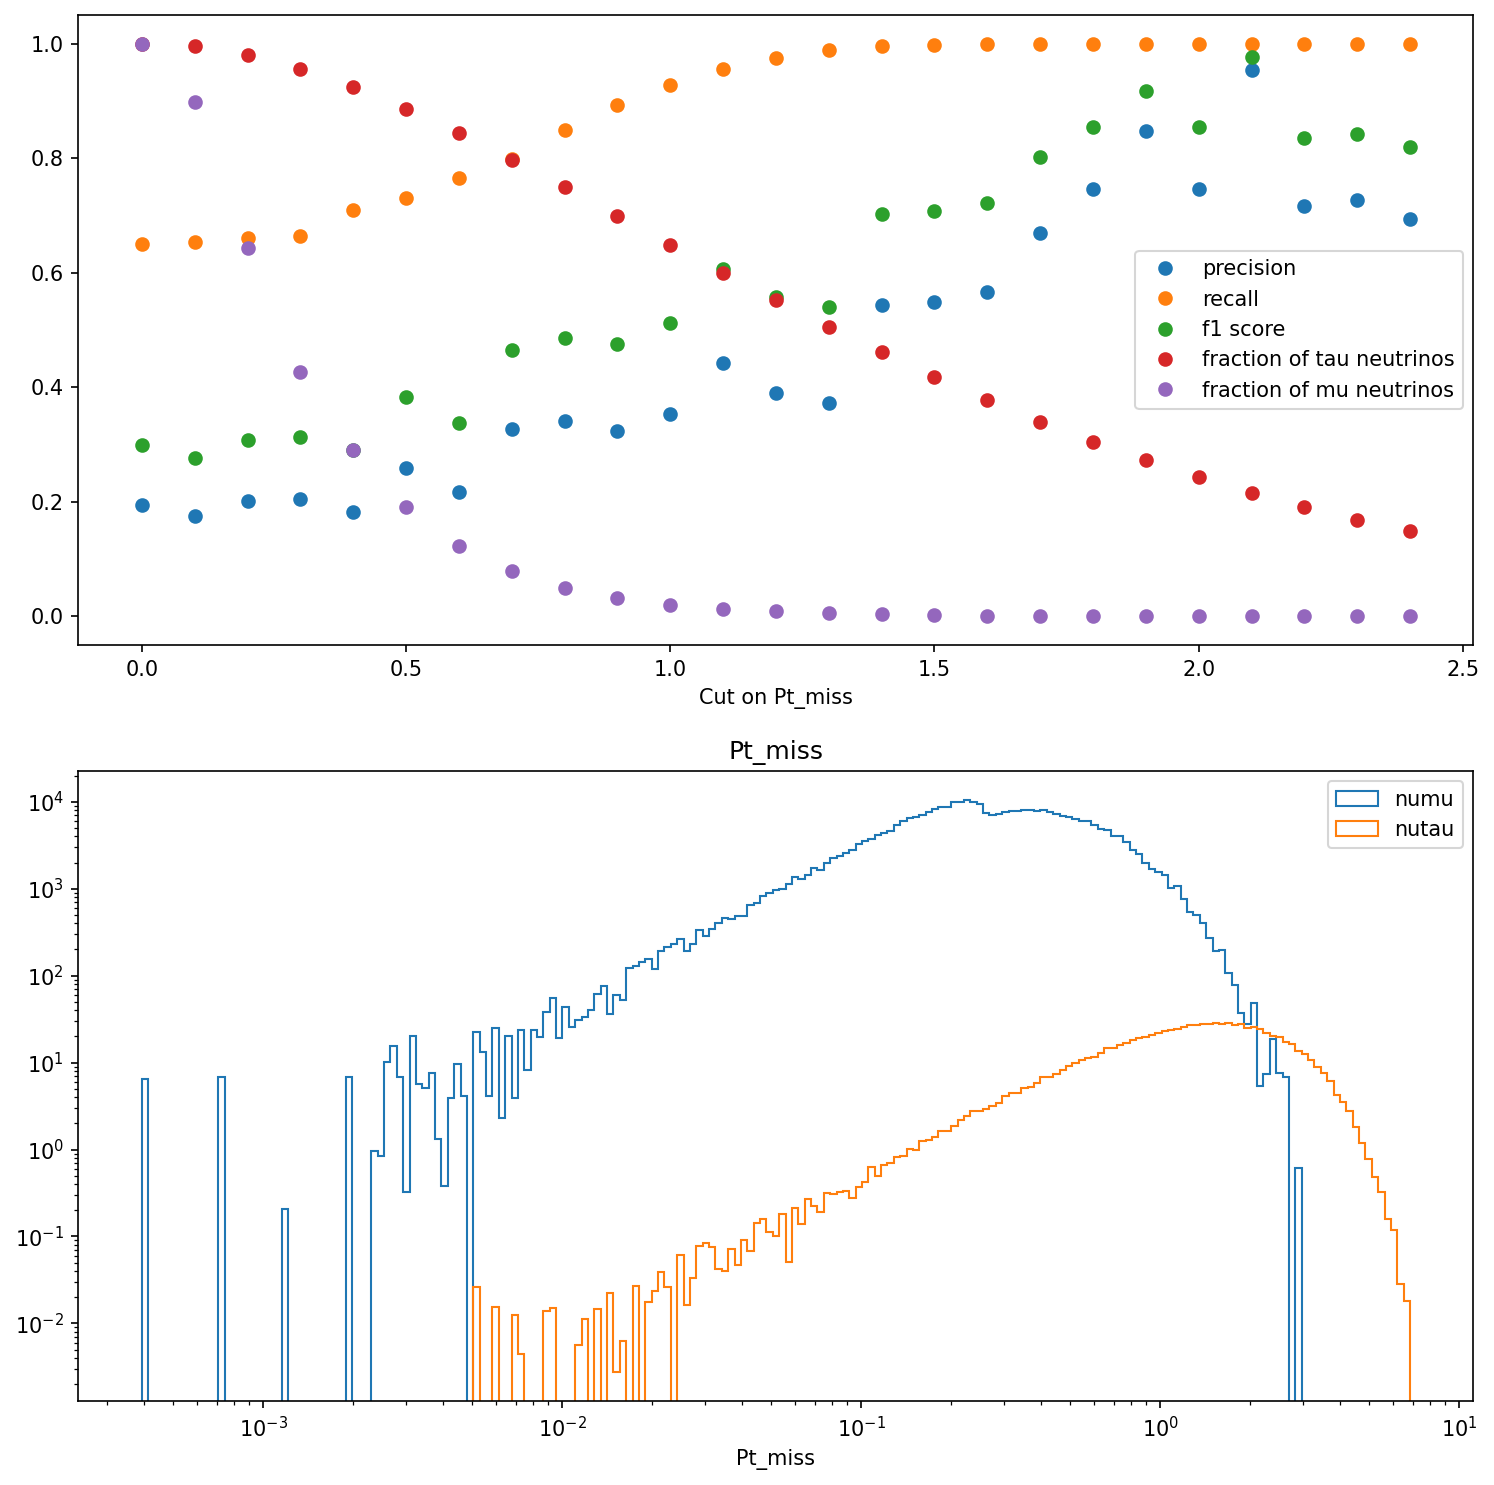

In [120]:
fig, ax = plt.subplots(2, 1, figsize = (12,12), dpi = 150)

ax[0].errorbar(cut_value_list, precision_list, fmt = "o", label = "precision")
ax[0].errorbar(cut_value_list, recall_list, fmt = "o", label = "recall")
ax[0].errorbar(cut_value_list, f1_list, fmt = "o", label = "f1 score")
ax[0].errorbar(cut_value_list, number_of_tau_neutrinos, fmt = "o", label = "fraction of tau neutrinos")
ax[0].errorbar(cut_value_list, number_of_mu_neutrinos, fmt = "o", label = "fraction of mu neutrinos")
ax[0].set_xlabel(f"Cut on {param}")
ax[0].legend()

list_of_interest_1 = [param]
Data_conv = df_muon_1


for param in list_of_interest_1:
    min_mu, min_tau = min(Data_conv.query("label == 'numu'")[param]), min(Data_conv.query("label == 'nutau'")[param])
    max_mu, max_tau = max(Data_conv.query("label == 'numu'")[param]), max(Data_conv.query("label == 'nutau'")[param])
    print(f"{param}. Range for numu: [{min_mu} {max_mu}]")
    print(f"{param}. Range for nutau: [{min_tau} {max_tau}]")
    if (min_tau > max_mu and max_tau > max_mu) or (min_tau < min_mu and max_tau < min_mu):
        print("alarm")
        
    if max_tau < max_mu and min_tau > min_mu:
        print(f"{param} is a bad parameter")
        bad_params.append(param)
    ranges.append(f"[{min(Data_conv[param]):.2f} {max(Data_conv[param]):.2f}]")
    bins = np.logspace(np.log10(min(Data_conv[param])), np.log10(max(Data_conv[param])), 200)
    ax[1].hist(Data_conv.query("label == 'numu'")[param], histtype = "step", 
            #density = True, 
            weights = Data_conv.query("label == 'numu'")["weight_mu"],
            bins = bins, label = "numu")
    ax[1].hist(Data_conv.query("label == 'nutau'")[param], histtype = "step", 
            #density = True, 
            weights = Data_conv.query("label == 'nutau'")["weight_mu"],
            bins = bins, label = "nutau")  
#     ax.set_xlim([0,60])
    ax[1].set_yscale("log")
    ax[1].set_xscale("log")
    ax[1].set_xlabel(param)
    ax[1].set_title(param)
    ax[1].legend()

In [63]:
max(prec_list)

1.0

In [3]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_validate, cross_val_score

def cut_study_cross_validation(df_muon_1, param, cut_value_list):
    precision_list, recall_list, f1_list, number_of_tau_neutrinos = [], [], [], []
    cross_val_metrics = ["f1", "recall", "precision"]    
    cross_val_metrics_vals = {key: [] for key in cross_val_metrics}
    cross_val_metrics_vals_err = {key: [] for key in cross_val_metrics}
    for cut_value in cut_value_list:
        #print(cut_value, cut_value_list)
        pca_num = 23
        pca = PCA(n_components=pca_num).set_output(transform = "pandas")
        preproc = pca
        #X_pca = X
        #X_pca = StandardScaler().fit_transform(X)
        # X_pca = preproc.fit_transform(X)
        # X_smeared = smear_data(X)
        # X_pca = preproc.fit_transform(X_smeared)
        #df_muon_2 = df_muon_1.loc[(df_muon_1["Pt_miss/E_mu"] > 7.5) & (df_muon_1["Pt_hadr_on_Pt_miss"] < -1.5)]

        df_muon_2 = df_muon_1.loc[df_muon_1[param] < cut_value]


        #df_muon_2 = df_muon_1.loc[:, ~df_muon_1.columns.isin(bad_params)]
        #df_muon_2 = df_muon_1
        # df_muon_2 = df_muon_1.loc[df_muon_1["Pt_miss/E_mu"] > 2.0]
        #print(df_muon_2.columns)
        #df_muon_2 = df_muon_1

        nutau_events_number = len(df_muon_2.query("label == 'nutau'")["E_mu"])
        weighted_nutau_events_number = df_muon_2.query("label == 'nutau'")["weight_mu"].sum()/df_muon_1.query("label == 'nutau'")["weight_mu"].sum()
        print(f"Number of nutau events {nutau_events_number}, percentage: {weighted_nutau_events_number*100}%")
        number_of_tau_neutrinos.append(weighted_nutau_events_number)


        X = df_muon_2.drop(columns=['label', 'weight_mu']).values
        y = df_muon_2["label"].map({'numu':0,'nutau':1}).values

        X_pca = X
        X_pca = np.hstack((X_pca, df_muon_2['weight_mu'].values.reshape(-1, 1)))

        # scaler = StandardScaler()

        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, df_muon_2["label"].map({'numu':0,'nutau':1}).values, 
            #random_state=13,  
            shuffle=True
        )

        # scaler = StandardScaler()

        weights_train = X_train[:,-1]
        X_train = X_train[:,:-1]
        #X_train = preproc.fit_transform(X_train[:,:-1])

        # X_train = scaler.fit_transform(X_train[:,:-1])
        #rf = RandomForestClassifier()
        # rf = lightgbm.LGBMClassifier(verbosity=-1)
        rf = LGBMClassifier(boosting_type = "gbdt", objective='binary', metric='binary_logloss', 
                               max_depth=-1, 
                               n_estimators=1, 
                               num_leaves = 31
                              )
        rf.fit(X_train, y_train,
               sample_weight = weights_train,
               # feature_name=[f"PC {i}" for i in range(1,pca_num+1)]
               #feature_name = list(X.columns)
              )
        weights_test = X_test[:,-1]
        X_test = X_test[:,:-1]

        y_pred = rf.predict(X_test)
        
        precision_list.append(precision_score(y_test, y_pred, sample_weight = weights_test))
        recall_list.append(recall_score(y_test, y_pred, sample_weight = weights_test))
        f1_list.append(f1_score(y_true=y_test, y_pred=y_pred, sample_weight=weights_test))
        
        for key in cross_val_metrics_vals:
                scores = cross_val_score(rf, X_train, y_train, cv=5, scoring = key, fit_params={'sample_weight': weights_train})
                cross_val_metrics_vals[key].append(scores.mean())              
                cross_val_metrics_vals_err[key].append(scores.std())
        
    return cross_val_metrics_vals, cross_val_metrics_vals_err, number_of_tau_neutrinos
        # X_test = pd.DataFrame(X_test)
        # X_test.columns = X.columns
        # X_test = smear_data(X_test).to_numpy()
        # X_test = preproc.fit_transform(X_test[:,:-1])
        # X_test = scaler.fit_transform(X_test[:,:-1])
        #print(classification_report(y_test, y_pred, sample_weight = weights_test))



In [10]:
cut_value_list = [i for i in range(6, 96, 6)]
param = "anglePhadrandPmuon"
cross_val_metrics_vals, cross_val_metrics_vals_err, number_of_tau_neutrinos = cut_study_cross_validation(df_muon_1, param, cut_value_list)




Number of nutau events 19747, percentage: 16.284635133749806%
[LightGBM] [Info] Number of positive: 14842, number of negative: 8585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 23427, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007587 -> initscore=-4.873738
[LightGBM] [Info] Start training from score -4.873738
[LightGBM] [Info] Number of positive: 11873, number of negative: 6868
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 18741, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007545 -> initscore=-4.879349
[Light

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 18742, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007543 -> initscore=-4.879595
[LightGBM] [Info] Start training from score -4.879595
[LightGBM] [Info] Number of positive: 11874, number of negative: 6868
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 18742, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007616 -> initscore=-4.869808
[LightGBM] [Info] Start training from score -4.869808
[LightGBM] [Info] Number of positive: 11873, number of negative: 6868
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [In

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


Number of nutau events 62208, percentage: 55.32558291232785%
[LightGBM] [Info] Number of positive: 46748, number of negative: 35746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 82494, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004885 -> initscore=-5.316637
[LightGBM] [Info] Start training from score -5.316637


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 37399, number of negative: 28596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 65995, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004902 -> initscore=-5.313257
[LightGBM] [Info] Start training from score -5.313257
[LightGBM] [Info] Number of positive: 37398, number of negative: 28597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 65995, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004891 -> initscore=-5.315531
[LightGBM] [Info] Start training from score -5.315531
[LightGBM] [

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 37398, number of negative: 28597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 65995, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004891 -> initscore=-5.315531
[LightGBM] [Info] Start training from score -5.315531
[LightGBM] [Info] Number of positive: 37398, number of negative: 28597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 65995, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004875 -> initscore=-5.318705
[LightGBM] [Info] Start training from score -5.318705
[LightGBM] [

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 37399, number of negative: 28596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 65995, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004902 -> initscore=-5.313257
[LightGBM] [Info] Start training from score -5.313257
[LightGBM] [Info] Number of positive: 37398, number of negative: 28597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 65995, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004891 -> initscore=-5.315531
[LightGBM] [Info] Start training from score -5.315531
[LightGBM] [

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 94394, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003757 -> initscore=-5.580477
[LightGBM] [Info] Start training from score -5.580477
[LightGBM] [Info] Number of positive: 50493, number of negative: 43901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 94394, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003739 -> initscore=-5.585109
[LightGBM] [Info] Start training from score -5.585109
[LightGBM] [Info] Number of positive: 50493, number of negative: 43901
[LightGBM] [

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 50493, number of negative: 43901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 94394, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003739 -> initscore=-5.585109
[LightGBM] [Info] Start training from score -5.585109
[LightGBM] [Info] Number of positive: 50493, number of negative: 43901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 94394, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003760 -> initscore=-5.579483
[LightGBM] [Info] Start training from score -5.579483
[LightGBM] [

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 50494, number of negative: 43900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 94394, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003757 -> initscore=-5.580477
[LightGBM] [Info] Start training from score -5.580477
[LightGBM] [Info] Number of positive: 50493, number of negative: 43901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 94394, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003739 -> initscore=-5.585109
[LightGBM] [Info] Start training from score -5.585109
[LightGBM] [

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 55591, number of negative: 51453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 107044, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003243 -> initscore=-5.728082
[LightGBM] [Info] Start training from score -5.728082
[LightGBM] [Info] Number of positive: 55591, number of negative: 51453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 107044, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003244 -> initscore=-5.727847
[LightGBM] [Info] Start training from score -5.727847
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 55591, number of negative: 51453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 107044, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003244 -> initscore=-5.727847
[LightGBM] [Info] Start training from score -5.727847
[LightGBM] [Info] Number of positive: 55591, number of negative: 51453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 107044, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003251 -> initscore=-5.725519
[LightGBM] [Info] Start training from score -5.725519
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 55591, number of negative: 51453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 107044, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003243 -> initscore=-5.728082
[LightGBM] [Info] Start training from score -5.728082
[LightGBM] [Info] Number of positive: 55591, number of negative: 51453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 107044, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003244 -> initscore=-5.727847
[LightGBM] [Info] Start training from score -5.727847
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 57943, number of negative: 55152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 113095, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003022 -> initscore=-5.798903
[LightGBM] [Info] Start training from score -5.798903
[LightGBM] [Info] Number of positive: 57943, number of negative: 55152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 113095, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003029 -> initscore=-5.796585
[LightGBM] [Info] Start training from score -5.796585
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 57943, number of negative: 55152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 113095, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003022 -> initscore=-5.798903
[LightGBM] [Info] Start training from score -5.798903
[LightGBM] [Info] Number of positive: 57943, number of negative: 55152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 113095, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003029 -> initscore=-5.796585
[LightGBM] [Info] Start training from score -5.796585
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 57943, number of negative: 55152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 113095, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003022 -> initscore=-5.798903
[LightGBM] [Info] Start training from score -5.798903
[LightGBM] [Info] Number of positive: 57943, number of negative: 55152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 113095, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003029 -> initscore=-5.796585


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 58683, number of negative: 57473
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 116156, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002875 -> initscore=-5.848658
[LightGBM] [Info] Start training from score -5.848658
[LightGBM] [Info] Number of positive: 58683, number of negative: 57474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 116157, number of used features: 21
[LightGBM] [Info

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 58683, number of negative: 57474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 116157, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002883 -> initscore=-5.846154
[LightGBM] [Info] Start training from score -5.846154
[LightGBM] [Info] Number of positive: 58683, number of negative: 57474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 116157, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002866 -> initscore=-5.851850
[LightGBM] [Info] Start training from score -5.851850
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 58683, number of negative: 57473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 116156, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002875 -> initscore=-5.848658
[LightGBM] [Info] Start training from score -5.848658
[LightGBM] [Info] Number of positive: 58683, number of negative: 57474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 116157, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002883 -> initscore=-5.846154


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59425, number of negative: 58238
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 117663, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002822 -> initscore=-5.867561
[LightGBM] [Info] Start training from score -5.867561
[LightGBM] [Info] Number of positive: 59425, number of negative: 58238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 117663, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002826 -> initscore=-5.866199


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 117663, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002822 -> initscore=-5.867561
[LightGBM] [Info] Start training from score -5.867561
[LightGBM] [Info] Number of positive: 59425, number of negative: 58238
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 117663, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002826 -> initscore=-5.866199
[LightGBM] [Info] Start training from score -5.866199
[LightGBM] [Info] Number of positive: 59425, number of negative: 58238
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59425, number of negative: 58238
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 117663, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002826 -> initscore=-5.866199
[LightGBM] [Info] Start training from score -5.866199
[LightGBM] [Info] Number of positive: 59425, number of negative: 58238
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 117663, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002822 -> initscore=-5.867523
[LightGBM] [Info] Start training from score -5.867523
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59701, number of negative: 58815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 118516, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002781 -> initscore=-5.882254
[LightGBM] [Info] Start training from score -5.882254
[LightGBM] [Info] Number of positive: 59701, number of negative: 58815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 118516, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002788 -> initscore=-5.879555
[LightGBM] [Info] Start training from score -5.879555
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59701, number of negative: 58815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 118516, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002781 -> initscore=-5.882254
[LightGBM] [Info] Start training from score -5.882254
[LightGBM] [Info] Number of positive: 59701, number of negative: 58815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 118516, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002788 -> initscore=-5.879555
[LightGBM] [Info] Start training from score -5.879555
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59701, number of negative: 58815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 118516, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002781 -> initscore=-5.882254
[LightGBM] [Info] Start training from score -5.882254
[LightGBM] [Info] Number of positive: 59701, number of negative: 58815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 118516, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002788 -> initscore=-5.879555


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59836, number of negative: 59184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119020, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002755 -> initscore=-5.891674
[LightGBM] [Info] Start training from score -5.891674
[LightGBM] [Info] Number of positive: 59836, number of negative: 59185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119021, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002769 -> initscore=-5.886358
[LightGBM] [Info] Start training from score -5.886358
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 119020, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002755 -> initscore=-5.891674
[LightGBM] [Info] Start training from score -5.891674
[LightGBM] [Info] Number of positive: 59836, number of negative: 59185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119021, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002769 -> initscore=-5.886358
[LightGBM] [Info] Start training from score -5.886358
[LightGBM] [Info] Number of positive: 59836, number of negative: 59185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59836, number of negative: 59185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119021, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002769 -> initscore=-5.886358
[LightGBM] [Info] Start training from score -5.886358
[LightGBM] [Info] Number of positive: 59836, number of negative: 59185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119021, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002762 -> initscore=-5.889206
[LightGBM] [Info] Start training from score -5.889206
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59854, number of negative: 59439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119293, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002749 -> initscore=-5.893899
[LightGBM] [Info] Start training from score -5.893899
[LightGBM] [Info] Number of positive: 59854, number of negative: 59439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119293, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002741 -> initscore=-5.896735
[LightGBM] [Info] Start training from score -5.896735
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59854, number of negative: 59439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119293, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002749 -> initscore=-5.893899
[LightGBM] [Info] Start training from score -5.893899
[LightGBM] [Info] Number of positive: 59854, number of negative: 59439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119293, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002741 -> initscore=-5.896735


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59854, number of negative: 59439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119293, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002749 -> initscore=-5.893899
[LightGBM] [Info] Start training from score -5.893899
[LightGBM] [Info] Number of positive: 59854, number of negative: 59439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119293, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002741 -> initscore=-5.896735
[LightGBM] [Info] Start training from score -5.896735
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59985, number of negative: 59507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119492, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002734 -> initscore=-5.899141
[LightGBM] [Info] Start training from score -5.899141
[LightGBM] [Info] Number of positive: 59985, number of negative: 59508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119493, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002735 -> initscore=-5.898944


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59985, number of negative: 59507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119492, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002734 -> initscore=-5.899141
[LightGBM] [Info] Start training from score -5.899141
[LightGBM] [Info] Number of positive: 59985, number of negative: 59508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119493, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002735 -> initscore=-5.898944


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59985, number of negative: 59507
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119492, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002734 -> initscore=-5.899141
[LightGBM] [Info] Start training from score -5.899141
[LightGBM] [Info] Number of positive: 59985, number of negative: 59508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119493, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002735 -> initscore=-5.898944


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59782, number of negative: 59850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119632, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002718 -> initscore=-5.905227
[LightGBM] [Info] Start training from score -5.905227
[LightGBM] [Info] Number of positive: 59782, number of negative: 59850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119632, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002718 -> initscore=-5.905301


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59782, number of negative: 59850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119632, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002718 -> initscore=-5.905227
[LightGBM] [Info] Start training from score -5.905227
[LightGBM] [Info] Number of positive: 59782, number of negative: 59850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119632, number of used features: 21
[LightGBM] [Info

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59782, number of negative: 59850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119632, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002718 -> initscore=-5.905227
[LightGBM] [Info] Start training from score -5.905227
[LightGBM] [Info] Number of positive: 59782, number of negative: 59850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119632, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002718 -> initscore=-5.905301
[LightGBM] [Info] Start training from score -5.905301
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 59823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119712, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002716 -> initscore=-5.905923
[LightGBM] [Info] Start training from score -5.905923
[LightGBM] [Info] Number of positive: 59889, number of negative: 59823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119712, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002700 -> initscore=-5.911928
[LightGBM] [Info] Start training from score -5.911928
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 59823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119712, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002716 -> initscore=-5.905923
[LightGBM] [Info] Start training from score -5.905923
[LightGBM] [Info] Number of positive: 59889, number of negative: 59823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119712, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002700 -> initscore=-5.911928


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 59823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119712, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002716 -> initscore=-5.905923
[LightGBM] [Info] Start training from score -5.905923
[LightGBM] [Info] Number of positive: 59889, number of negative: 59823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119712, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002700 -> initscore=-5.911928
[LightGBM] [Info] Start training from score -5.911928
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 60010, number of negative: 59762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119772, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002724 -> initscore=-5.902760
[LightGBM] [Info] Start training from score -5.902760
[LightGBM] [Info] Number of positive: 60010, number of negative: 59762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119772, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002716 -> initscore=-5.906051
[LightGBM] [Info] Start training from score -5.906051
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 60010, number of negative: 59762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119772, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002724 -> initscore=-5.902760
[LightGBM] [Info] Start training from score -5.902760
[LightGBM] [Info] Number of positive: 60010, number of negative: 59762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119772, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002716 -> initscore=-5.906051


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 60010, number of negative: 59762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119772, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002724 -> initscore=-5.902760
[LightGBM] [Info] Start training from score -5.902760
[LightGBM] [Info] Number of positive: 60010, number of negative: 59762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119772, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002716 -> initscore=-5.906051


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59961, number of negative: 59854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119815, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002715 -> initscore=-5.906112
[LightGBM] [Info] Start training from score -5.906112
[LightGBM] [Info] Number of positive: 59961, number of negative: 59854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119815, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002728 -> initscore=-5.901433
[LightGBM] [Info] Start training from score -5.901433
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59961, number of negative: 59854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119815, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002715 -> initscore=-5.906112
[LightGBM] [Info] Start training from score -5.906112
[LightGBM] [Info] Number of positive: 59961, number of negative: 59854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119815, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002728 -> initscore=-5.901433
[LightGBM] [Info] Start training from score -5.901433
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59961, number of negative: 59854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119815, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002715 -> initscore=-5.906112
[LightGBM] [Info] Start training from score -5.906112
[LightGBM] [Info] Number of positive: 59961, number of negative: 59854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119815, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002728 -> initscore=-5.901433


In [9]:
cut_value_list

[36, 72, 108, 144, 180, 216, 252, 288, 324, 360, 396, 432, 468, 504, 540]

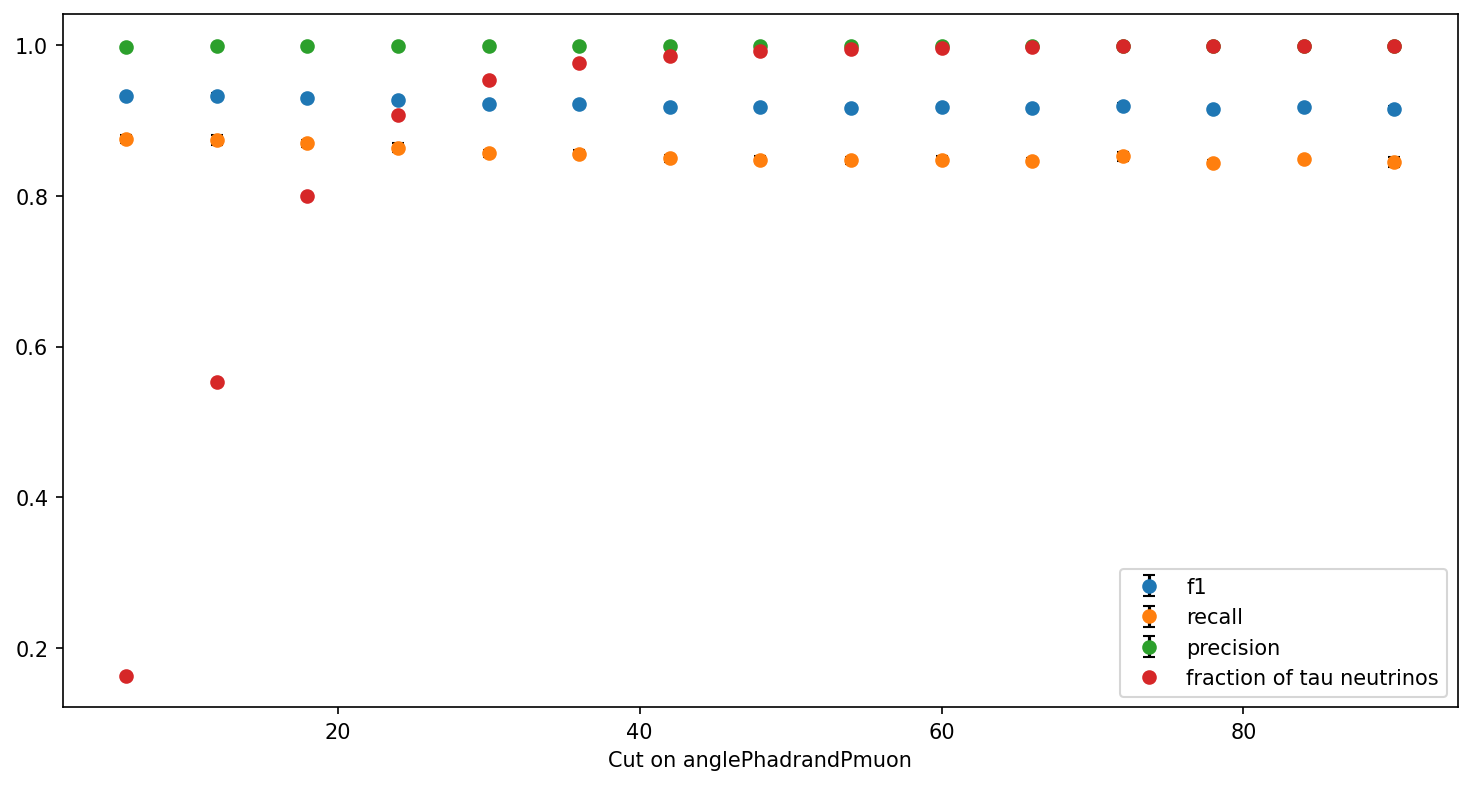

In [11]:
fig, ax = plt.subplots(figsize = (12,6), dpi = 150)


for key in cross_val_metrics_vals:
    ax.errorbar(y = cross_val_metrics_vals[key], x = cut_value_list, yerr = cross_val_metrics_vals_err[key], capsize=3, fmt="o", ecolor = "black", label = key)

ax.errorbar(x = cut_value_list, y = number_of_tau_neutrinos, fmt = "o", label = "fraction of tau neutrinos")

ax.set_xlabel(f"Cut on {param}")
ax.legend()

In [92]:

rf = lightgbm.LGBMClassifier(verbosity=-1)
cross_val_score(rf, X_train, y_train, cv=5, scoring = "f1", fit_params={'sample_weight': weights_train})


array([0.98431891, 0.98333333, 0.98607823, 0.98532892, 0.98485422])

In [35]:
# f1 score. Bootstrap
def bootstrap_metric(x, 
                     y,
                     w,
                     metric_fn,
                     samples_cnt = 100,
                     alpha = 0.05,
                     random_state = 42):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        w_boot = w[poses]
        
        m_val = metric_fn(x_boot, y_boot, w_boot)
        b_metric[it] = m_val
        if it%10 == 0:
            print(it, "...")
    
    return b_metric
alpha = 0.05
y_pred = rf.predict(X_test)
cor = accuracy_score(y_test, y_pred)
print(precision_score(y_true=y_test, y_pred=y_pred, sample_weight = weights_test))
boot_mat_score = bootstrap_metric(y_test, y_pred, weights_test, metric_fn=lambda x, y, w: f1_score(y_true=x, y_pred=y, sample_weight=w) , alpha = alpha)
print("Model: {0}".format("Random Forest"), " \t f1-score: ", np.quantile(boot_mat_score, q=[alpha/2, 1 - alpha/2]))



0.3200374050402049
0 ...
10 ...
20 ...
30 ...
40 ...
50 ...
60 ...
70 ...
80 ...
90 ...
Model: Random Forest  	 f1-score:  [0.34607839 0.73993382]


In [5]:
df["label"].map({'numu':0,'nutau':1}).values

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
def train_and_test(df, encoding_dim = 12, learning_rate = 1e-3, batch_size = 32):
    # Generate a sample dataset for demonstration purposes
    np.random.seed(42)
    # df = pd.DataFrame(np.random.randn(1000, 25), columns=[f'feature_{i}' for i in range(25)])
    # df['target'] = [0]*995 + [1]*5  # Rare events in the last 5 rows

    # # Separate features and target
    # X = df.drop(columns=['target']).values
    # y = df['target'].values

    X = df.drop(columns=['label']).values
    y = df["label"].map({'numu':0,'nutau':1}).values

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    # Define the autoencoder model
    input_dim = X_train.shape[1]
    # you can tune this parameter

#     input_layer = Input(shape=(input_dim,))
#     encoder = Dense(encoding_dim, activation="relu")(input_layer)
#     decoder = Dense(input_dim, activation="sigmoid")(encoder)
#     autoencoder = Model(inputs=input_layer, outputs=decoder)

    hidden_dim = int(encoding_dim / 2)
#     input_layer = Input(shape=(input_dim, ))
#     encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
#     encoder = Dense(hidden_dim, activation="relu")(encoder)
#     decoder = Dense(hidden_dim, activation="relu")(encoder)
#     decoder = Dense(encoding_dim, activation="relu")(decoder)
#     decoder = Dense(input_dim, activation="linear")(decoder)
#     autoencoder = Model(inputs=input_layer, outputs=decoder)
#     autoencoder.summary()

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation="relu")(input_layer)
    decoder = Dense(input_dim, activation="sigmoid")(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                                   save_best_only=True,
                                   verbose=0)
    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    # Train the model
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=batch_size, shuffle=True, validation_split=0.2, verbose=1)

    # Predict and calculate reconstruction error
    X_train_pred = autoencoder.predict(X_train)
    train_loss = np.mean(np.square(X_train - X_train_pred), axis=1)

    X_test_pred = autoencoder.predict(X_test)
    test_loss = np.mean(np.square(X_test - X_test_pred), axis=1)

    # Determine a threshold for anomaly detection
    threshold = np.percentile(train_loss, 95)  # 95th percentile

    # Classify anomalies
    y_train_pred = (train_loss > threshold).astype(int)
    y_test_pred = (test_loss > threshold).astype(int)

    # Evaluate the model
    from sklearn.metrics import classification_report

    print("Train Classification Report:")
    print(classification_report(y_train, y_train_pred))

    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))

In [17]:
train_and_test(df)

Epoch 1/50
200/200 [==============================] - 2s 4ms/step - loss: 1.1995 - val_loss: 0.7871
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.9668 - val_loss: 0.6380
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.8761 - val_loss: 0.5882
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.8422 - val_loss: 0.5657
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.8248 - val_loss: 0.5528
Epoch 6/50
200/200 [==============================] - 1s 3ms/step - loss: 0.8142 - val_loss: 0.5445
Epoch 7/50
200/200 [==============================] - 1s 3ms/step - loss: 0.8070 - val_loss: 0.5387
Epoch 8/50
200/200 [==============================] - 1s 3ms/step - loss: 0.8017 - val_loss: 0.5343
Epoch 9/50
200/200 [==============================] - 1s 3ms/step - loss: 0.7975 - val_loss: 0.5306
Epoch 10/50
200/200 [==============================] - 1s 3ms/step - loss: 0.7936 - val_loss: 0.5276

In [92]:
Data["mu"].query("Event == 228")

,Event,Number,id,m_id,name,px,py,pz,E,final,Xin,Yin,Zin,Rin,weight
6805,228,0,14,-1,nu_mu,0.000000,0.000000,41.867600,41.867600,0,-0.486526,2.173380,-0.338937,2.252813,4.150174
6806,228,1,1000260560,-1,Fe56,0.000000,0.000000,0.000000,52.089800,0,0.000000,0.000000,0.000000,0.000000,4.150174
6807,228,2,2112,1,neutron,-0.155074,0.092967,-0.145504,0.927842,0,-0.486526,2.173380,-0.338937,2.252813,4.150174
6808,228,3,1000260550,1,Fe55,0.155074,-0.092967,0.145504,51.161900,0,0.000000,0.000000,0.000000,0.000000,4.150174
6809,228,4,13,0,mu-,0.429380,2.148540,36.731900,36.797400,1,-0.486526,2.173380,-0.338937,2.252813,4.150174
6810,228,5,2000000001,2,HadrSyst,-0.584454,-2.055570,4.990150,5.998050,0,0.000000,0.000000,0.000000,0.000000,4.150174
6811,228,6,2112,5,neutron,0.084508,-0.393422,0.534461,1.153410,0,-0.260709,1.122090,1.089220,1.585388,4.150174
6812,228,7,211,5,pi+,-0.069369,-0.687194,1.399020,1.566460,0,-1.254510,-5.434490,15.149500,16.143569,4.150174
6813,228,8,211,5,pi+,-0.397419,-0.540110,1.799530,1.925480,0,-3.974740,-2.567250,15.455800,16.163882,4.150174
6814,228,9,-211,5,pi-,-0.202174,-0.434844,1.257130,1.352710,0,-1.132190,0.784659,3.675850,3.925483,4.150174


In [54]:
hadr = Data["mu"].query("Event == 228 & ~(id == 13 & m_id == 0) & m_id != -1 & final == 1")
hadr

,Event,Number,id,m_id,name,px,py,pz,E,final,Xin,Yin,Zin,Rin,weight
6815,228,10,2212,6,proton,-0.110485,-0.351529,0.468167,1.111450,1,-0.260709,1.122090,1.08922,1.585388,4.150174
6816,228,11,2112,6,neutron,0.191980,-0.088548,-0.061051,0.964991,1,-0.260709,1.122090,1.08922,1.585388,4.150174
6817,228,12,211,7,pi+,-0.069369,-0.687194,1.399020,1.566460,1,-1.254510,-5.434490,15.14950,16.143569,4.150174
6818,228,13,211,8,pi+,-0.397419,-0.540110,1.799530,1.925480,1,-3.974740,-2.567250,15.45580,16.163882,4.150174
6820,228,15,2212,14,proton,0.196731,-0.201297,0.136155,0.988998,1,-1.132190,0.784659,3.67585,3.925483,4.150174
6821,228,16,2212,14,proton,-0.123647,-0.156261,-0.328548,1.013910,1,-1.132190,0.784659,3.67585,3.925483,4.150174
6822,228,17,2212,14,proton,-0.007595,-0.148719,0.187111,0.968267,1,-1.132190,0.784659,3.67585,3.925483,4.150174
6823,228,18,2212,14,proton,-0.175749,-0.137415,0.319621,1.016010,1,-1.132190,0.784659,3.67585,3.925483,4.150174
6824,228,19,2212,14,proton,0.151942,-0.028652,0.245163,0.982022,1,-1.132190,0.784659,3.67585,3.925483,4.150174
6825,228,20,2212,14,proton,0.054096,-0.106085,0.162305,0.959624,1,-1.132190,0.784659,3.67585,3.925483,4.150174


In [94]:
muon = Data["mu"].query("Event == 228 & (id == 13 & m_id == 0)")
muon

,Event,Number,id,m_id,name,px,py,pz,E,final,Xin,Yin,Zin,Rin,weight
6809,228,4,13,0,mu-,0.42938,2.14854,36.7319,36.7974,1,-0.486526,2.17338,-0.338937,2.252813,4.150174


In [95]:
muon["px"] + hadr["px"].sum()

6809   -0.158086
Name: px, dtype: float64

In [82]:
df_muon.query("label == 'numu' & Pt_miss > 1")[["Pt_miss", "Pt_miss_old", "px_mu", "py_mu", "px_hadr", "py_hadr"]]

,Pt_miss,Pt_miss_old,px_mu,py_mu,px_hadr,py_hadr
15,2.079477,0.128648,-1.327350,-1.18136,1.430201,1.104081
23,2.612576,0.602395,0.459635,0.64973,-0.775123,-1.162903
31,1.035924,0.277423,-2.626970,-3.49575,2.629766,3.773159
36,1.520412,0.459687,1.723210,2.11154,-1.645775,-2.564659
52,1.808500,1.135347,-0.867084,2.57177,1.631144,-3.411547
...,...,...,...,...,...,...
99960,2.057182,0.514351,1.294370,-2.00378,-0.864978,2.286940
99973,1.070236,0.701612,1.154830,1.33736,-1.448637,-1.974491
99983,1.099992,0.214468,-2.036540,-2.97234,2.044701,3.186652
99985,1.596661,0.664629,-0.571826,1.35772,0.679567,-0.701882


In [81]:
df_muon.query("label == 'numu' & Pt_miss_old > 1")[["Pt_miss", "Pt_miss_old", "px_mu", "py_mu", "px_hadr", "py_hadr"]]

,Pt_miss,Pt_miss_old,px_mu,py_mu,px_hadr,py_hadr
19,0.952107,1.222561,0.417784,2.536200,-0.067412,-1.364921
52,1.808500,1.135347,-0.867084,2.571770,1.631144,-3.411547
75,0.201075,1.084413,-2.744220,-1.805760,2.572376,0.735049
161,0.241703,1.055690,-0.434898,1.080920,0.610887,-0.040002
215,2.503520,1.011448,0.448208,-0.379951,0.129659,1.210070
...,...,...,...,...,...,...
99765,0.840325,1.129326,-4.530050,-2.576390,4.351995,1.461189
99785,0.355680,1.327014,-1.766950,1.073290,0.948419,-2.117787
99855,1.556843,1.246523,-1.570700,-0.750408,2.776170,1.067679
99874,1.986323,1.871348,0.436145,-0.230394,-1.494773,-1.312735


<Axes: >

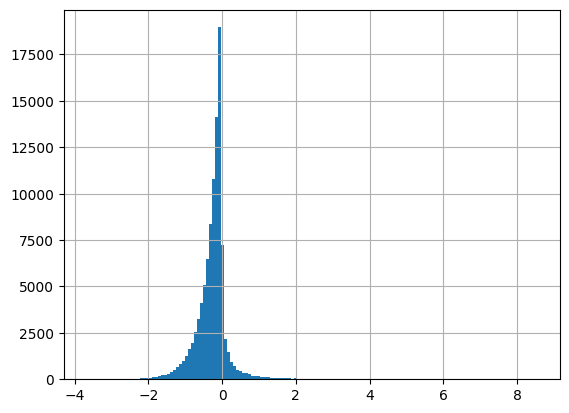

In [86]:
(df_muon.query("label == 'numu'")["Pt_miss"] - df_muon.query("label == 'numu'")["Pt_miss_old"]).hist(bins = 150)

<Axes: >

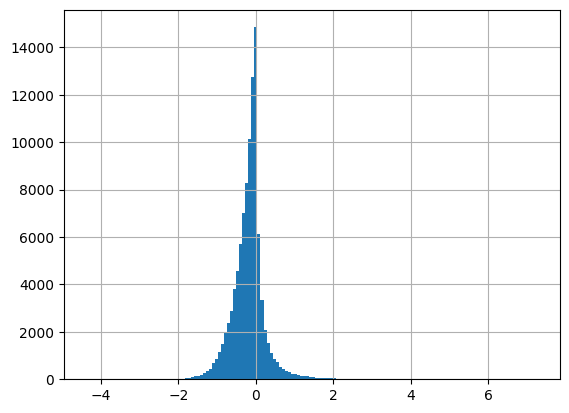

In [87]:
(df_muon.query("label == 'nutau'")["Pt_miss"] - df_muon.query("label == 'nutau'")["Pt_miss_old"]).hist(bins = 150)

In [91]:
dif = (df_muon.query("label == 'numu'")["Pt_miss"] - df_muon.query("label == 'numu'")["Pt_miss_old"])
dif[dif > 1.]

228      1.386346
321      1.273667
323      1.704824
509      3.105970
526      1.000973
           ...   
99511    1.809767
99557    1.727890
99740    1.983018
99795    2.683379
99912    1.040096
Length: 1279, dtype: float64

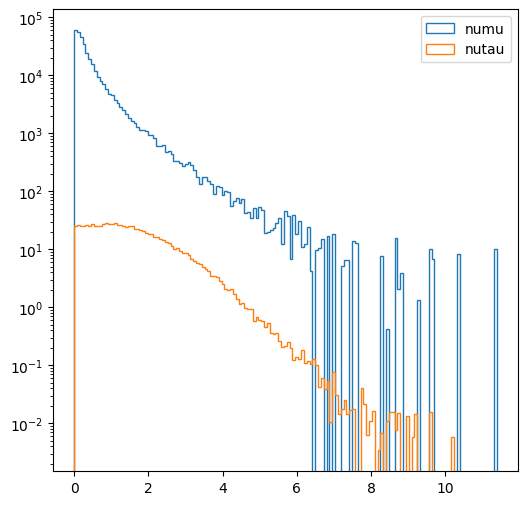

In [137]:
fig, ax = plt.subplots(figsize = (6,6))
bins = np.linspace(df_muon["Pt_miss"].min(), df_muon["Pt_miss"].max(), 150)
ax.hist(df_muon.query("label == 'numu'")["Pt_miss"], weights = df_muon.query("label == 'numu'")["weight_mu"], histtype = "step", bins = bins, label = "numu")
ax.hist(df_muon.query("label == 'nutau'")["Pt_miss"], weights = df_muon.query("label == 'nutau'")["weight_mu"], histtype = "step", bins = bins, label = "nutau")
ax.set_yscale("log")
ax.legend()

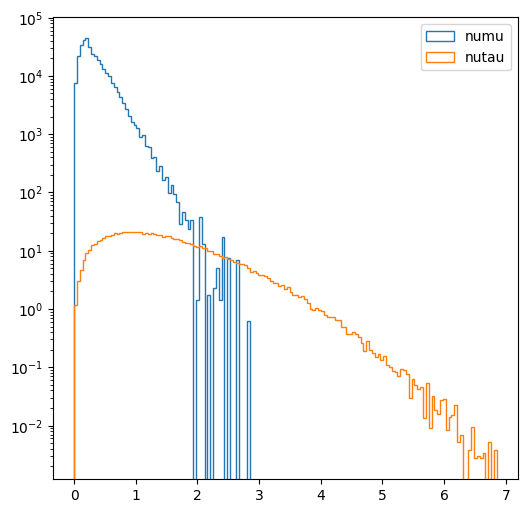

In [138]:
fig, ax = plt.subplots(figsize = (6,6))
param = df_muon["Pt_miss_old"]
bins = np.linspace(df_muon["Pt_miss_old"].min(), df_muon["Pt_miss_old"].max(), 150)
ax.hist(df_muon.query("label == 'numu'")["Pt_miss_old"], weights = df_muon.query("label == 'numu'")["weight_mu"], histtype = "step", bins = bins, label = "numu")
ax.hist(df_muon.query("label == 'nutau'")["Pt_miss_old"], weights = df_muon.query("label == 'nutau'")["weight_mu"], histtype = "step", bins = bins, label = "nutau")
ax.set_yscale("log")
ax.legend()

<Axes: >

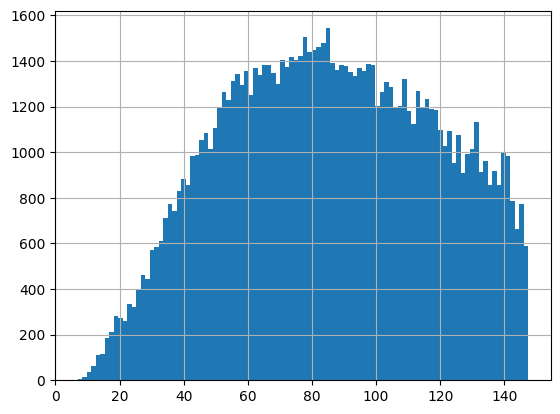

In [135]:
Data["tau"].query("abs(id) == 16 & m_id == -1")["E"].hist(bins = 100)

<Axes: >

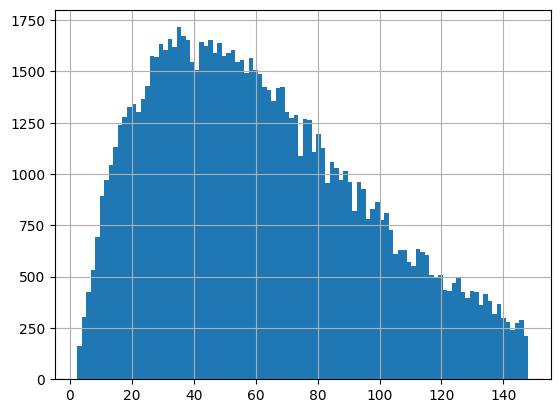

In [140]:
Data["mu"].query("abs(id) == 14 & m_id == -1")["E"].hist(bins = 100)

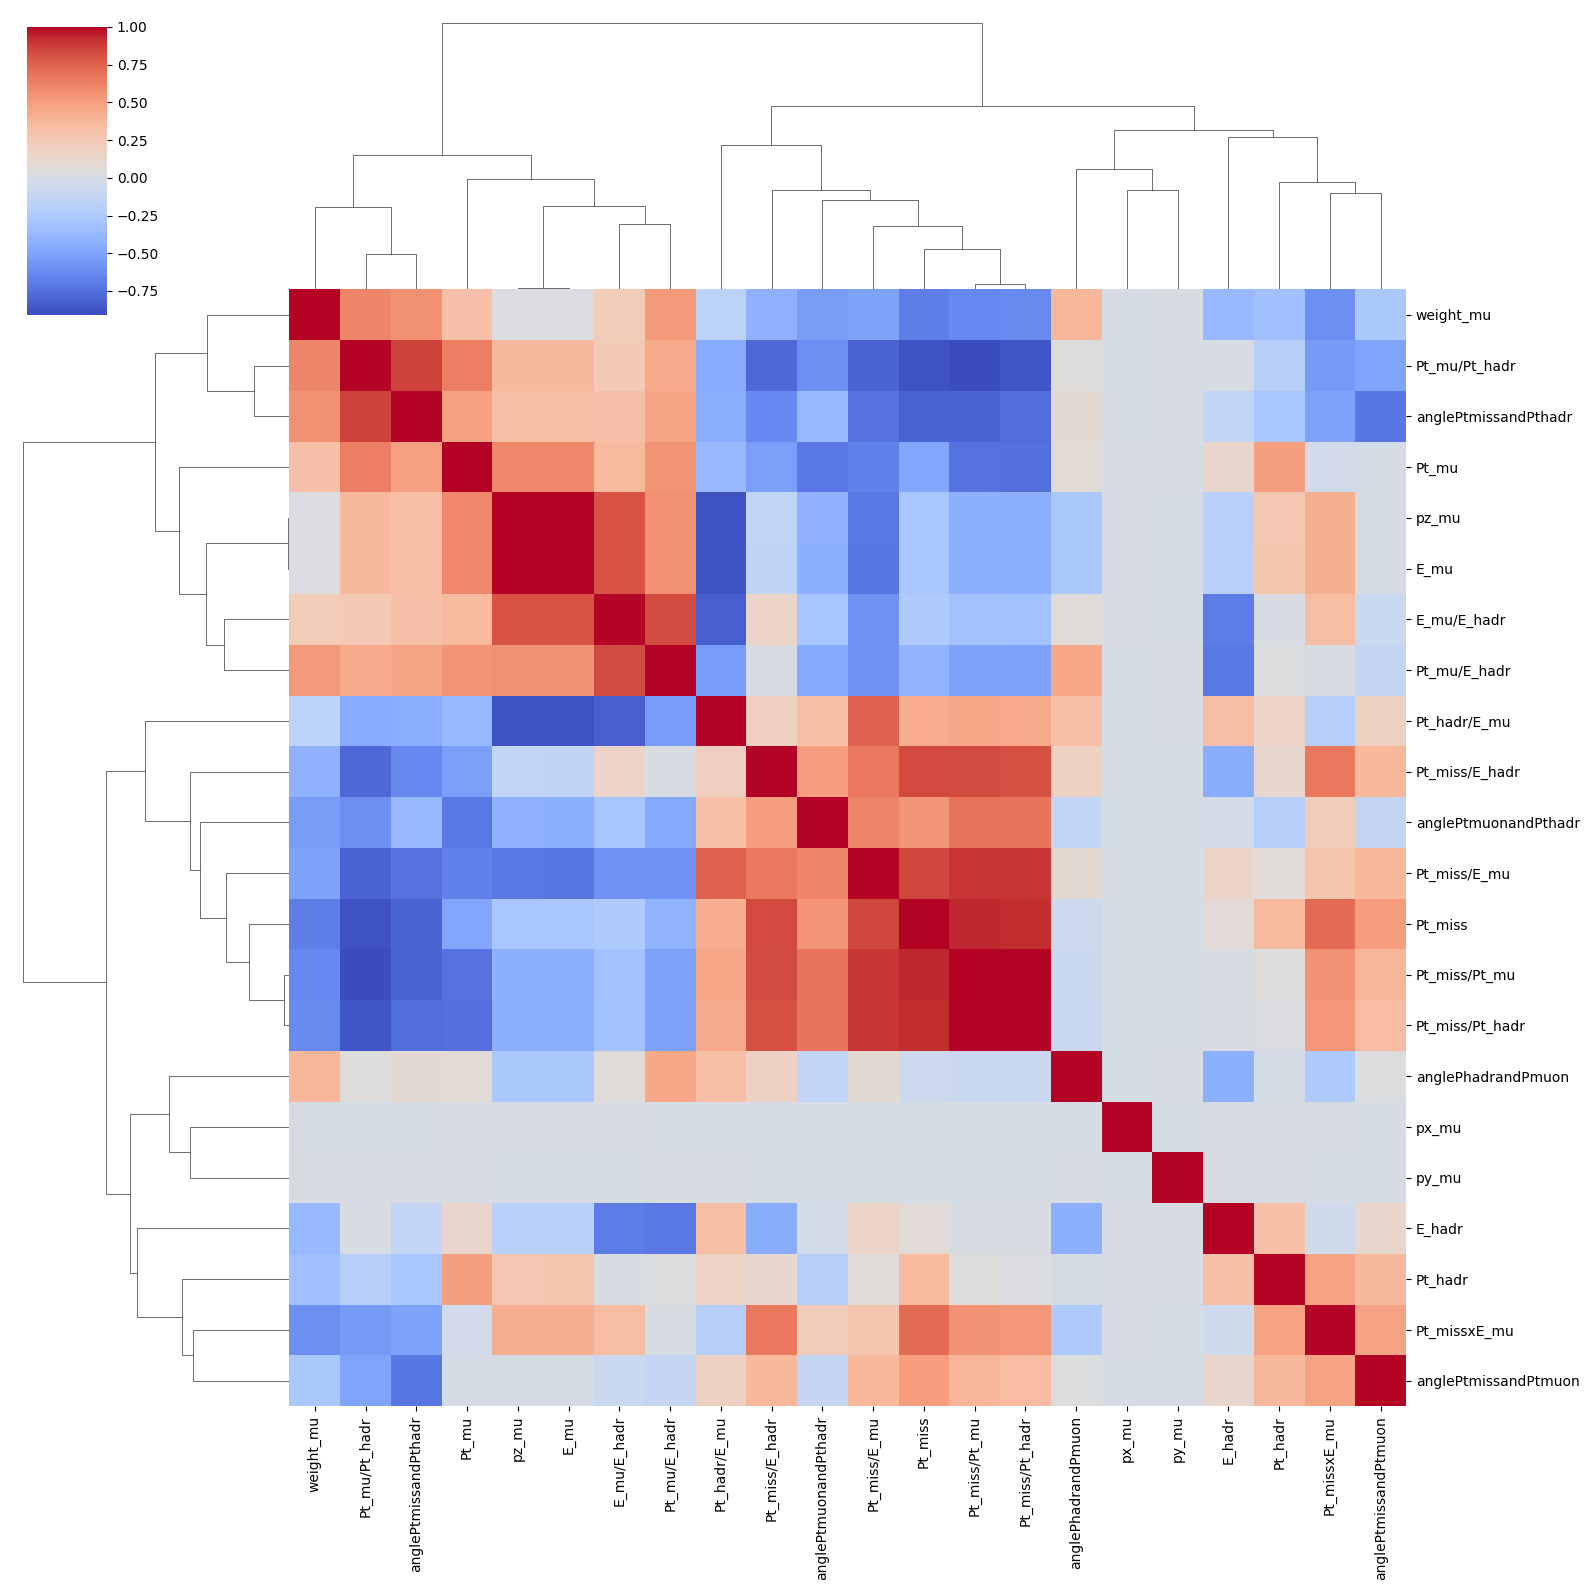

In [68]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import datasets 
import seaborn as sns
corr_matrix = df_muon_1.drop(columns = ["label"]).corr(method='spearman')
# fig, ax1 = plt.subplots(figsize = (8,8), dpi = 200)
res = sns.clustermap(corr_matrix, method='weighted', cmap='coolwarm', figsize=(16, 16))
plt.savefig('corr_matrix_0.pdf', format='pdf')

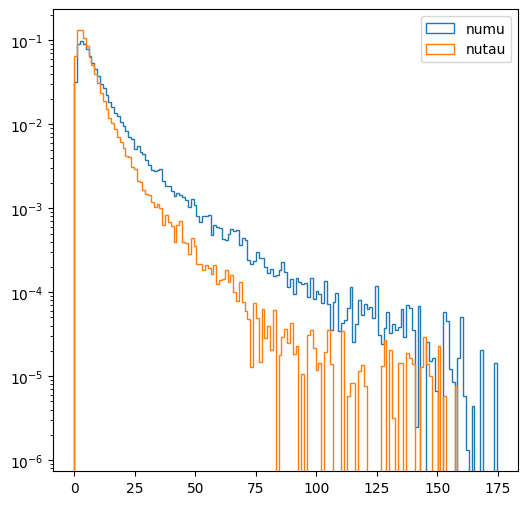

In [72]:
fig, ax = plt.subplots(figsize = (6,6))
df_muon["theta_hadr"] = 180*np.arccos(df_muon["pz_mu"]/np.sqrt(df_muon["px_mu"]**2 + df_muon["py_mu"]**2 + df_muon["pz_mu"]**2))/np.pi
bins = np.linspace(df_muon["theta_hadr"].min(), df_muon["theta_hadr"].max(), 150)
ax.hist(df_muon.query("label == 'numu'")["theta_hadr"], density = True, weights = df_muon.query("label == 'numu'")["weight_mu"], histtype = "step", bins = bins, label = "numu")
ax.hist(df_muon.query("label == 'nutau'")["theta_hadr"], density = True, weights = df_muon.query("label == 'nutau'")["weight_mu"], histtype = "step", bins = bins, label = "nutau")
ax.set_yscale("log")
ax.legend()